# Projeto Integrador 2

## Estudo de Caso: DeliverEase 

A empresa fictícia DeliverEase, uma plataforma de entrega de 
alimentos que opera em diversos estados do país. 

- A empresa processa, em média, 10.000 pedidos diários, conectando clientes a 
restaurantes e fornecedores locais. 
- O maior desafio atual é a imprecisão na previsão do tempo de entrega, que gera: 
    - atrasos inesperados, 
    - insatisfação dos clientes, 
    - aumento no volume de reclamações, 
    - 15% de taxa de cancelamento. 

Além do impacto direto na experiência do usuário, a empresa estima um custo médio de R$ 
1,00 por minuto de atraso. O modelo atual apresenta um erro médio absoluto de 10 minutos, o 
que representa perdas financeiras relevantes e danos à reputação da marca. 
Diante deste cenário, o cientista de dados sênior da DeliverEase foi convocado pelo 
CEO para investigar e propor uma solução mais robusta para o problema de previsão do 
tempo de entrega.

## Imports:

In [187]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from boruta import BorutaPy
from IPython.display import Image, HTML
from datetime import datetime
from geopy.distance import geodesic
from sklearn.preprocessing import RobustScaler, LabelEncoder
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Dataset:

In [2]:
df_raw = pd.read_csv("../data/data_delivery.csv")

## 1.0 Descrição dos Dados:

In [3]:
df1 = df_raw.copy()

### 1.1 Dimensão dos Dados

In [4]:
print("Quantidade de linhas: {}".format(df1.shape[0]))
print("Quantidade de colunas: {}".format(df1.shape[1]))

Quantidade de linhas: 45593
Quantidade de colunas: 20


### 1.2 Tipos dos Dados

In [5]:
df1.dtypes

ID                              object
Delivery_person_ID              object
Delivery_person_Age            float64
Delivery_person_Ratings        float64
Restaurant_latitude            float64
Restaurant_longitude           float64
Delivery_location_latitude     float64
Delivery_location_longitude    float64
Order_Date                      object
Time_Orderd                     object
Time_Order_picked               object
Weatherconditions               object
Road_traffic_density            object
Vehicle_condition                int64
Type_of_order                   object
Type_of_vehicle                 object
multiple_deliveries            float64
Festival                        object
City                            object
Time_taken(min)                 object
dtype: object

### 1.3 Checando os Dados Nulos

In [6]:
df1.isna().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions                 0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries               0
Festival                          0
City                              0
Time_taken(min)                   0
dtype: int64

### 1.4 Tratando os Dados Nulos

In [7]:
# Ajustando as colunas de data e hora para o tipo certo
df1['Order_Date'] = pd.to_datetime(df1['Order_Date'], errors='coerce')
df1['Time_Orderd'] = pd.to_datetime(df1['Time_Orderd'], errors='coerce').dt.time
df1['Time_Order_picked'] = pd.to_datetime(df1['Time_Order_picked'], errors='coerce').dt.time

# Combinando colunas (mantendo hora e data juntos)
df1['ordered_date_time'] = df1.apply(
    lambda row: datetime.combine(row['Order_Date'].date(), row['Time_Orderd'])
    if pd.notnull(row['Order_Date']) and pd.notnull(row['Time_Orderd']) else pd.NaT,
    axis=1
)

df1['order_picked_date_time'] = df1.apply(
    lambda row: datetime.combine(row['Order_Date'].date(), row['Time_Order_picked'])
    if pd.notnull(row['Order_Date']) and pd.notnull(row['Time_Order_picked']) else pd.NaT,
    axis=1
)

# Coluna de diferença de datas
df1['time_diff'] = df1['ordered_date_time'] - df1['order_picked_date_time'] 

#mediana:
median_diff = df1['time_diff'].median()

#inserindo a mediana da diferença de tempo para os dados nulos:
df1['ordered_date_time'] = df1.apply(
    lambda row: row['order_picked_date_time'] + median_diff 
    if pd.isnull(row['ordered_date_time'])
    else row['ordered_date_time'],
    axis =1
)

df1['Time_Orderd'] = df1['ordered_date_time']
df1['Time_Order_picked'] = df1['order_picked_date_time'] 

df1.drop(columns = ['time_diff', 'ordered_date_time', 'order_picked_date_time'], inplace = True)

C:\Users\samso\AppData\Local\Temp\ipykernel_34848\853991514.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Time_Orderd'] = pd.to_datetime(df1['Time_Orderd'], errors='coerce').dt.time
C:\Users\samso\AppData\Local\Temp\ipykernel_34848\853991514.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Time_Order_picked'] = pd.to_datetime(df1['Time_Order_picked'], errors='coerce').dt.time


### 1.5 Ajustando os Tipos de Dados

In [8]:
#função para extrair o valor da variável resposta:

def extrair_valor(texto):
    match = re.search(r'\d+', texto)
    if match:
        return int(match.group())
    else:
        return None

#extraindo o valor:
df1['Time_taken(min)'] = df1['Time_taken(min)'].apply(extrair_valor)

### 1.6 Estatística Descritiva

In [9]:
#variáveis numéricas:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

#variáveis categóricas:
cat_attributes = df1.select_dtypes(include = ['object'])

#### 1.6.1 Dados Numéricos

In [10]:
#medidas de tendência central:

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T     #média
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T   #mediana

#medidas de dispersão:
d1 = pd.DataFrame(num_attributes.apply(np.std)).T                               #desvio-padrão
d2 = pd.DataFrame(num_attributes.apply(min)).T                                  #mínimo
d3 = pd.DataFrame(num_attributes.apply(max)).T                                  #máximo
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T          #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T                   #assimetria
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T               #curtose

#concatenar:
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Delivery_person_Age,18.000000,50.000000,32.000000,29.424583,29.000000,5.733407,0.090328,-1.038405
1,Delivery_person_Ratings,1.000000,6.000000,5.000000,4.636552,4.700000,0.327902,-2.566185,16.508814
2,Restaurant_latitude,-30.905562,30.914057,61.819619,17.017729,18.546947,8.185019,-1.361583,3.713716
3,Restaurant_longitude,-88.366217,88.433452,176.799669,70.231332,75.898497,22.883396,-3.220159,10.303039
4,Delivery_location_latitude,0.010000,31.054057,31.044057,17.465186,18.633934,7.335042,-0.701066,0.264346
5,Delivery_location_longitude,0.010000,88.563452,88.553452,70.845702,76.002574,21.118580,-2.956385,7.104451
6,Vehicle_condition,0.000000,3.000000,3.000000,1.023359,1.000000,0.839056,0.071853,-1.315002
7,multiple_deliveries,0.000000,3.000000,3.000000,0.750225,1.000000,0.567424,0.298735,0.950328
8,Time_taken(min),10.000000,54.000000,44.000000,26.294607,26.000000,9.383703,0.485951,-0.310798


#### 1.6.2 Dados Categóricos

In [11]:
cat_attributes.describe().T

,count,unique,top,freq
ID,45593,45593,0x4607,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Weatherconditions,45593,6,conditions Cloudy,8152
Road_traffic_density,45593,4,Low,16078
Type_of_order,45593,4,Snack,11533
Type_of_vehicle,45593,4,motorcycle,26435
Festival,45593,2,No,44697
City,45593,3,Metropolitian,35293


## 2.0 Feature Engineering:

In [12]:
df2 = df1. copy()

### 2.1 Mapa Mental de Hipóteses

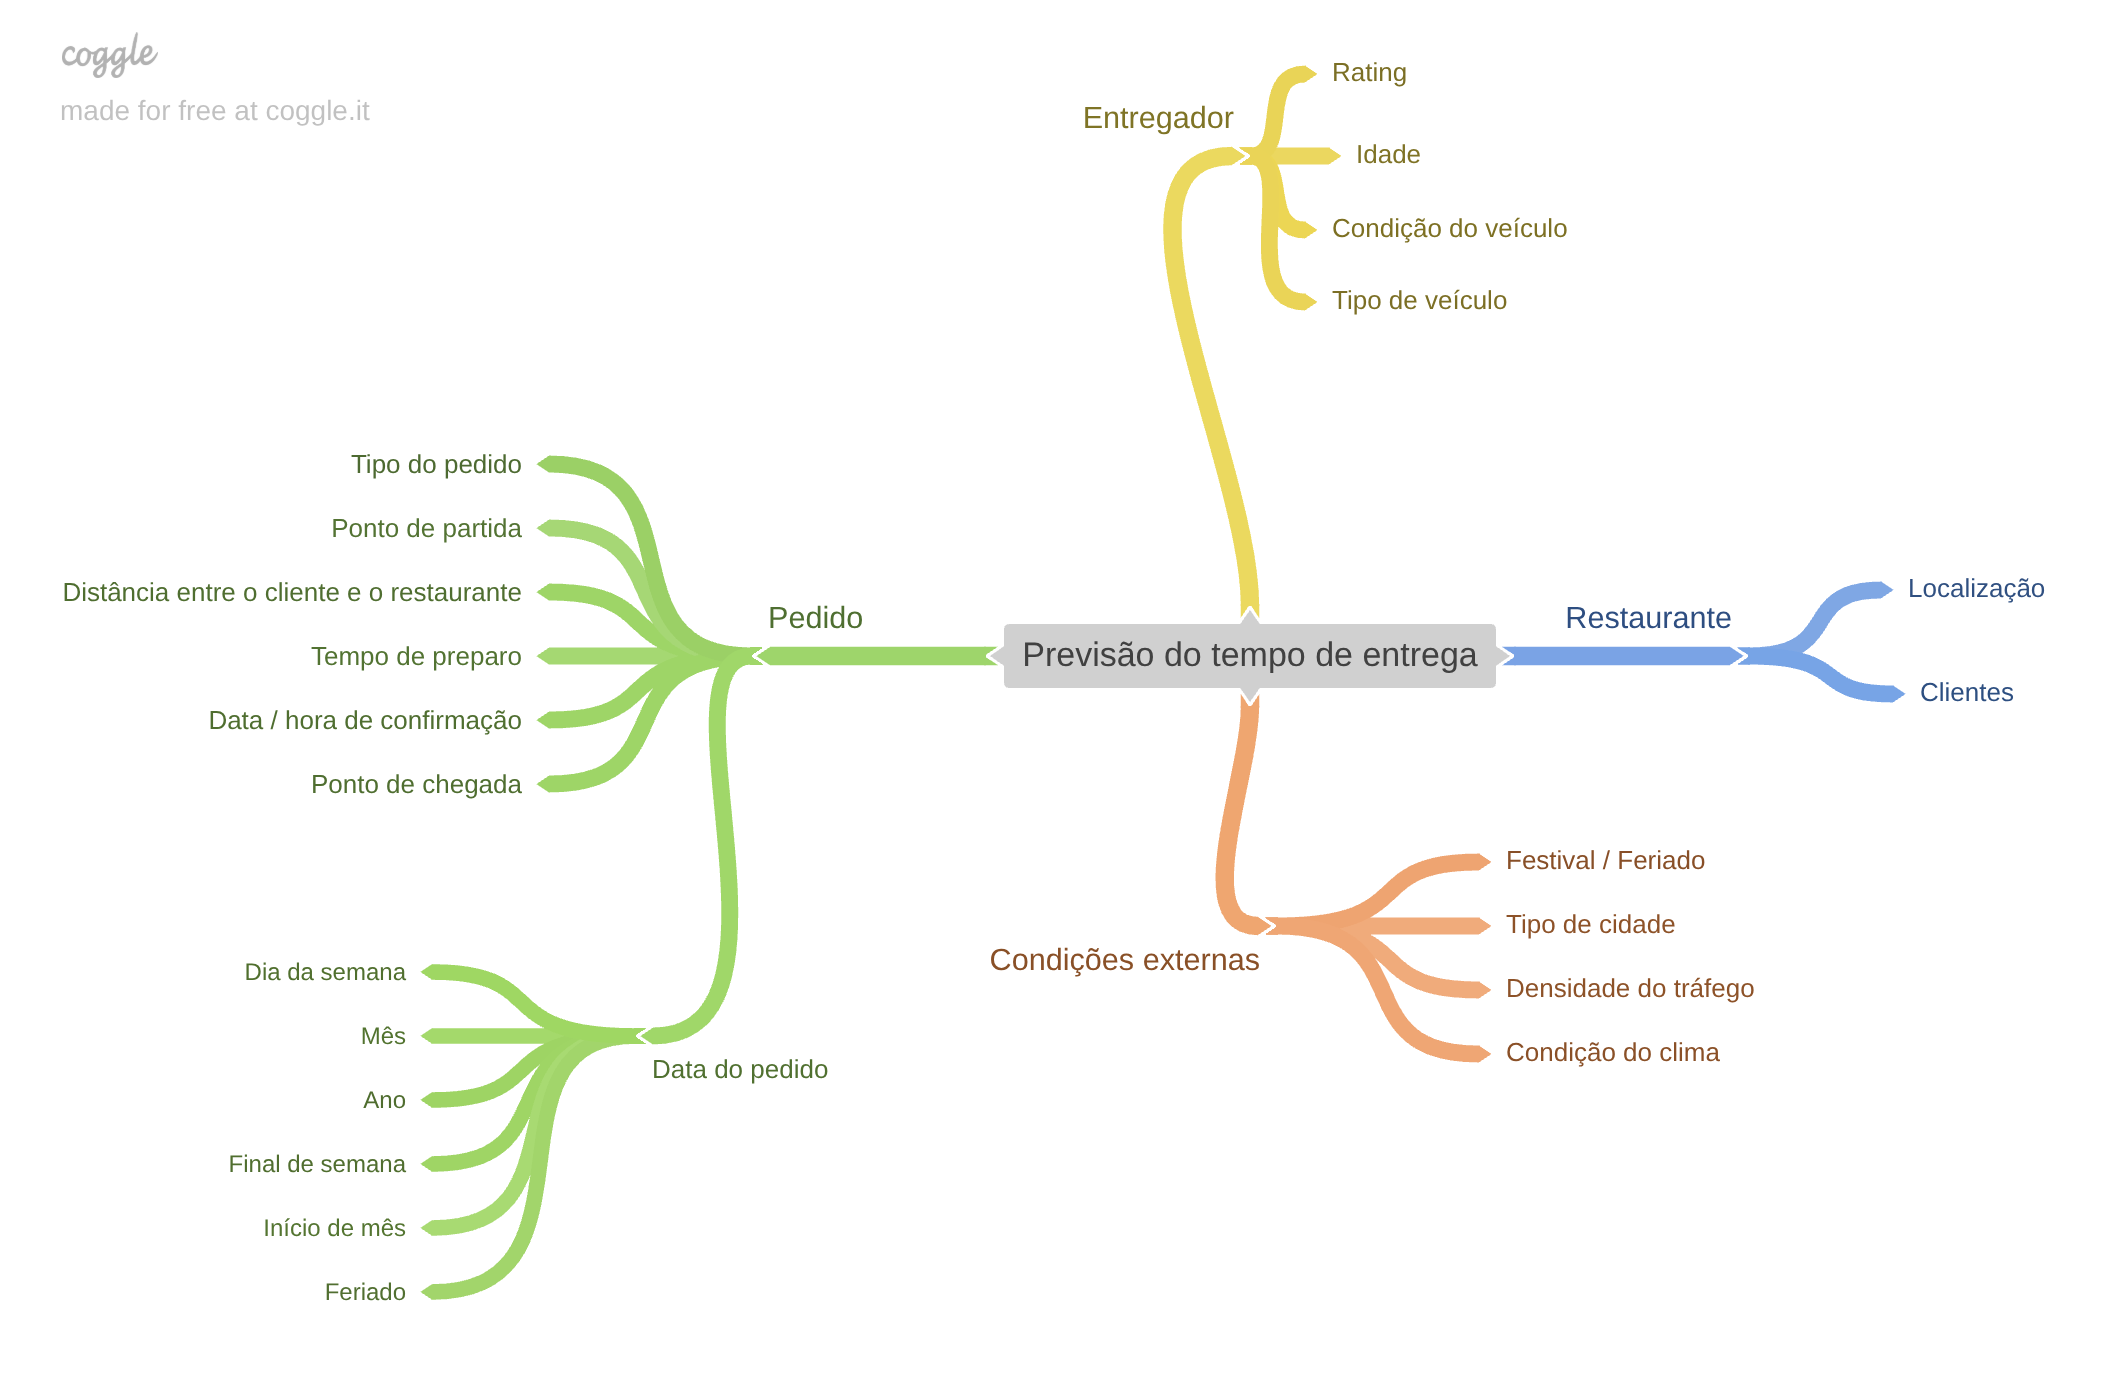

In [13]:
Image('../data/mindmap_hipoteses.png')

### 2.2 Lista de Hipóteses

#### 2.2.1 Hipóteses do Pedido:

- Quanto maior o tempo de preparo do pedido maior o tempo de entrega;

- Quanto maior a distância entre o restaurante e o cliente maior o tempo de entrega;

- Pedidos aos finais de semana possuem maior tempo de entrega;

- Pedidos no começo do mês possuem maior tempo de entrega;

- Tipos específicos de pedidos podem exigir diferentes tempos de entrega;

#### 2.2.2 Hipóteses do Entregador:

- A idade do entregador afeta a velocidade da entrega;

- Avaliações do entregador podem impactar a eficiência da entrega;

- O tipo de veículo usado para a entrega pode impactar no tempo de entrega;

- Múltiplas entregas em uma única rota podem aumentar o tempo de entrega;

- A condição do veículo pode influenciar o tempo de entrega

#### 2.2.3 Hipóteses das Condições Externas:

-  Condições climáticas adversas podem aumentar o tempo de entrega;

- A densidade do tráfego pode impactar o tempo de entrega;

- Festivais ou eventos na cidade podem afetar o tempo de entrega

### 2.3 Feature Engineering

In [14]:
#criando novas colunas de dia, mês, trimestre, ano, início e fim de mês, de semestre, de ano, fim de semana:

df2['day'] = df2.Order_Date.dt.day
df2['month'] = df2.Order_Date.dt.month
df2['quarter'] = df2.Order_Date.dt.quarter
df2['year'] = df2.Order_Date.dt.year
df2['day_of_week'] = df2.Order_Date.dt.day_of_week.astype(int)
df2['is_month_start'] = df2.Order_Date.dt.is_month_start.astype(int)
df2['is_month_end'] = df2.Order_Date.dt.is_month_end.astype(int)
df2['is_quarter_start'] = df2.Order_Date.dt.is_quarter_start.astype(int)
df2['is_quarter_end'] = df2.Order_Date.dt.is_quarter_end.astype(int)
df2['is_year_start'] = df2.Order_Date.dt.is_year_start.astype(int)
df2['is_year_end'] = df2.Order_Date.dt.is_year_end.astype(int)
df2['is_weekend'] = np.where(df2['day_of_week'].isin([5,6]),1,0)

In [15]:
#funções:

#tempo de preparo do pedido:

def calculate_time_diff(df):
    time_diff = df['Time_Order_picked'] - df['Time_Orderd']
    time_diff = time_diff.apply(lambda x: x + pd.Timedelta(days=1) if x.days <0 else x)
    df['order_prepare_time'] = time_diff.dt.total_seconds()/60
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace = True)

calculate_time_diff(df2)

In [16]:
#diferença da distância:

def calculate_distance(df):
    df['distance'] = np.zeros(len(df))
    restaurante_coordinates = df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
    cliente_coordinates = df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
    df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurante_coordinates, cliente_coordinates)])
    df['distance'] = df['distance'].astype('str').str.extract('(\d+)').astype('int64')

calculate_distance(df2)

In [17]:
df2.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,2022-03-19 11:30:00,...,5,0,0,0,0,0,0,1,15.0,3
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,2022-03-25 19:45:00,...,4,0,0,0,0,0,0,0,5.0,20
2,0x5d6d,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,2022-03-19 08:30:00,...,5,0,0,0,0,0,0,1,15.0,1
3,0x7a6a,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,2022-04-05 18:00:00,...,1,0,0,0,0,0,0,0,10.0,7
4,0x70a2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,2022-03-26 13:30:00,...,5,0,0,0,0,0,0,1,15.0,6


## 3.0 Filtragem dos Dados

In [18]:
df3 = df2.copy()

#### 3.1 Filtragem de Linhas

#### 3.2 Filtragem de Colunas

In [19]:
df3 = df3.drop(columns = ['ID', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked'])

## 4.0 Análise Exploratória de Dados:

In [20]:
df4 = df3.copy()

### 4.1 Análise Univariada

#### 4.1.1 Variável Resposta

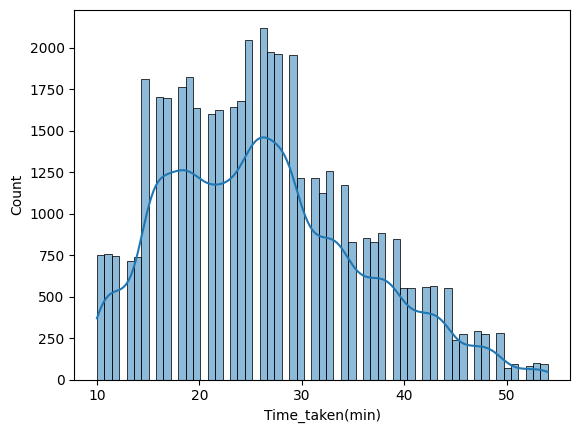

In [21]:
#variável resposta

sns.histplot(df4['Time_taken(min)'], kde=True)
plt.show()

#### 4.1.2 Variáveis Numéricas

In [22]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [30,16]
    plt.rcParams['font.size'] = 24

    display(HTML ('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

jupyter_settings()

In [23]:
#variáveis numéricas:
num_attributes = df4.select_dtypes(include = ['int64', 'float64', 'int32'])

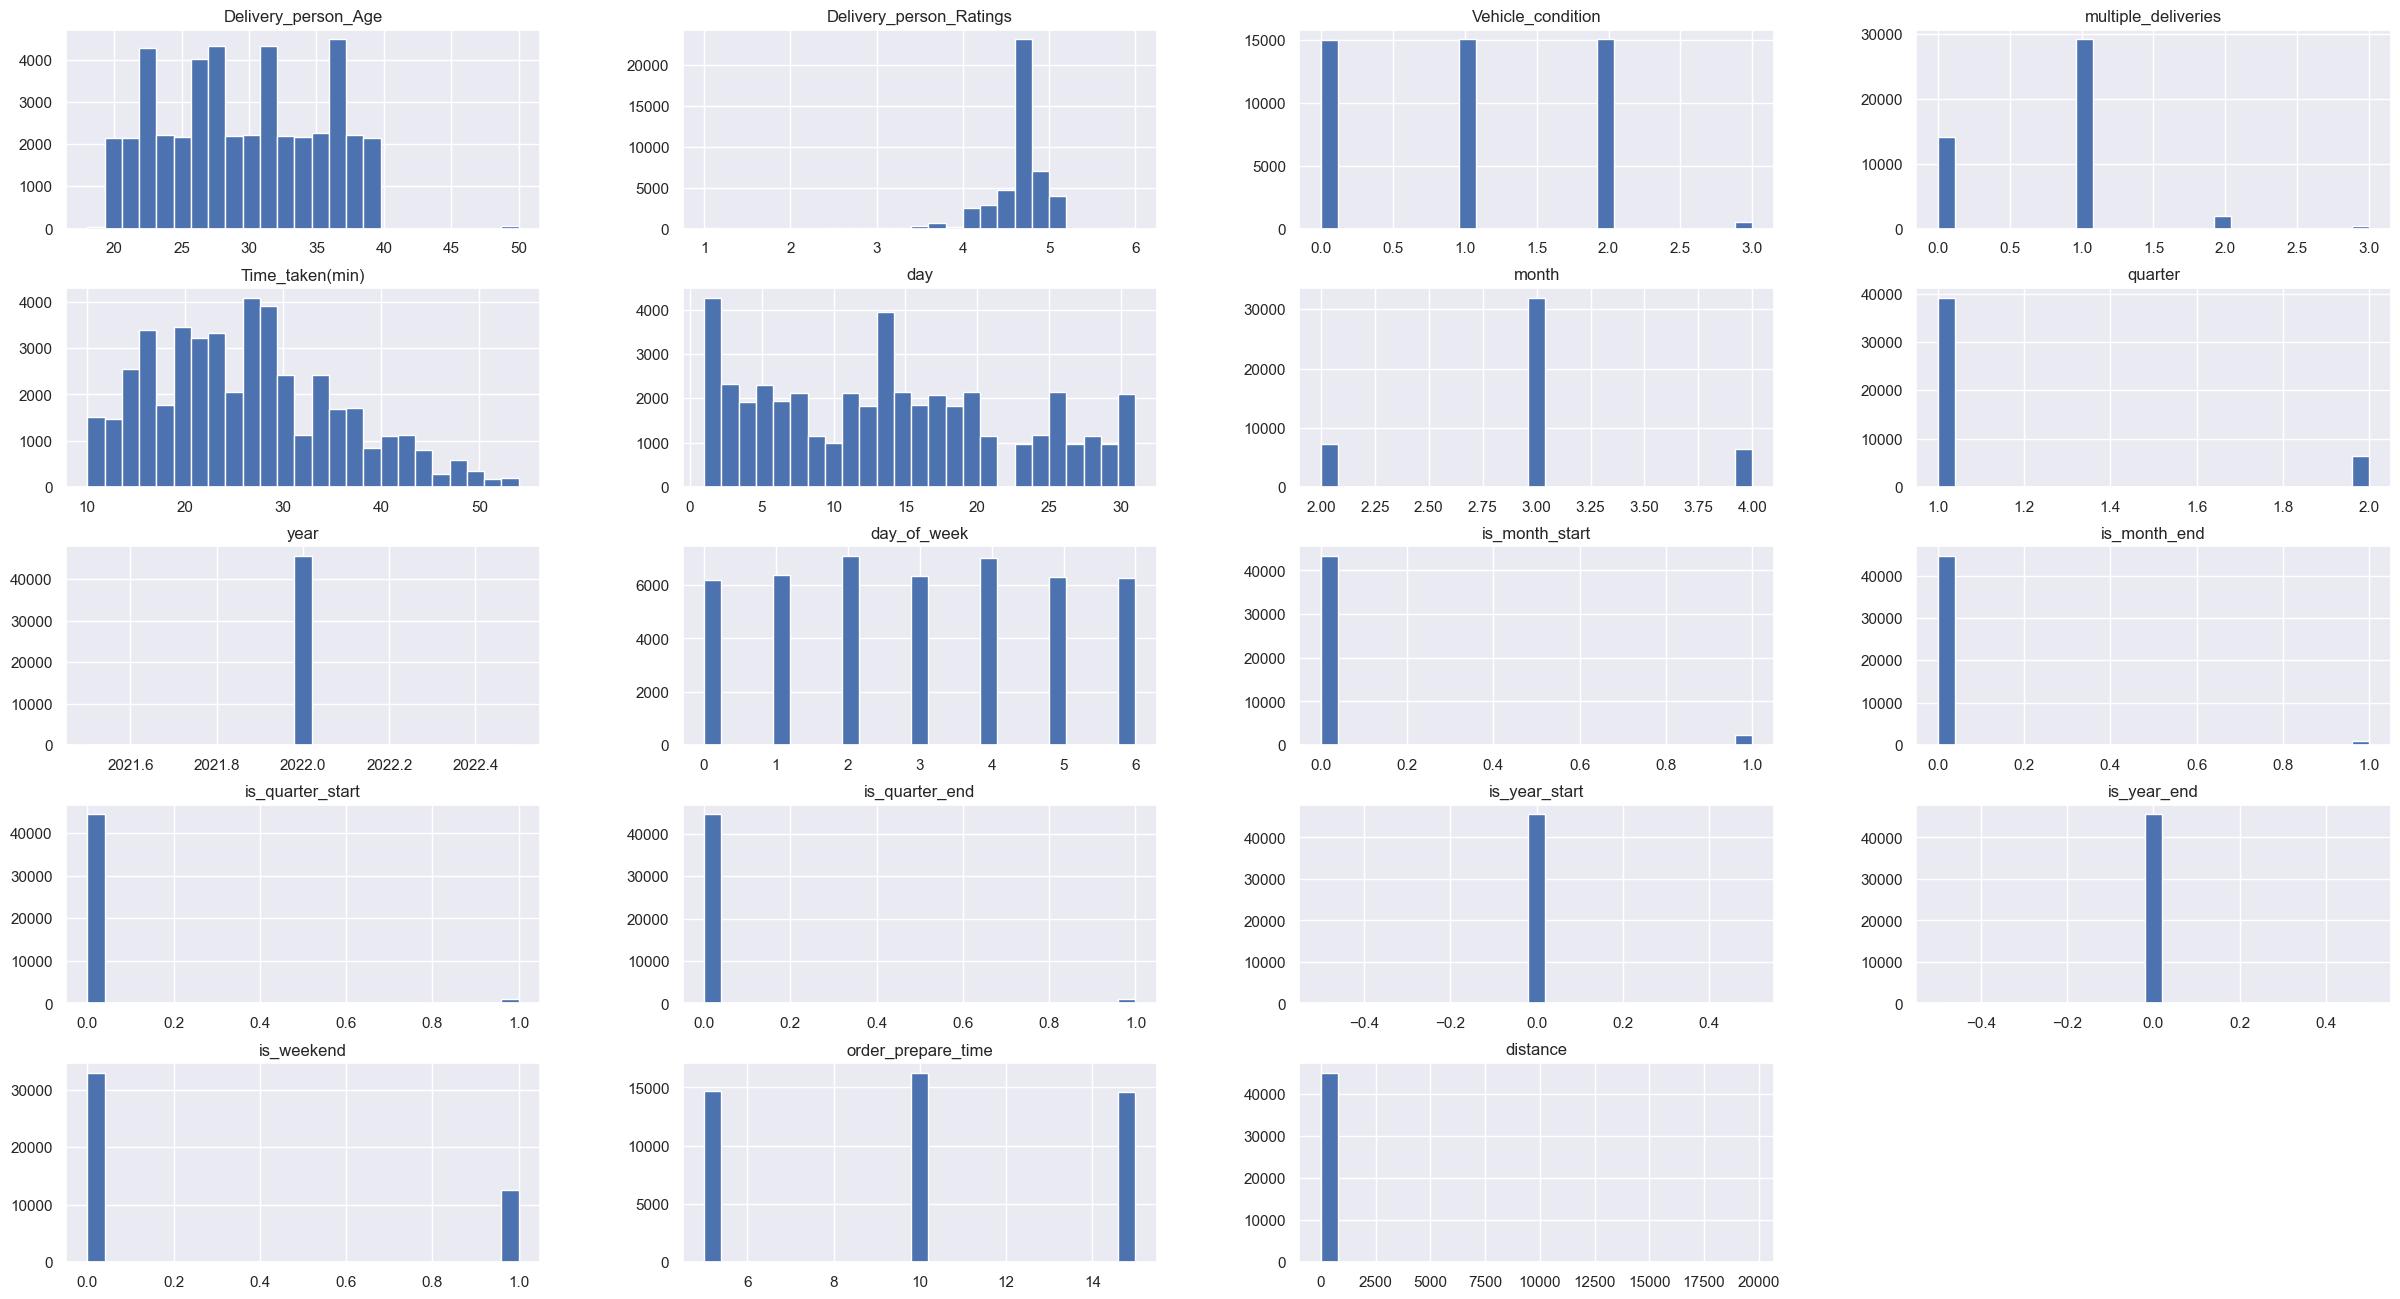

In [24]:
num_attributes.hist(bins = 25);

#### 4.1.3 Variáveis Categóricas

In [25]:
#retirando os espaços:

df4['Road_traffic_density'] = df4['Road_traffic_density'].str.strip()
df4['Type_of_order'] = df4['Type_of_order'].str.strip()
df4['Type_of_vehicle'] = df4['Type_of_vehicle'].str.strip()

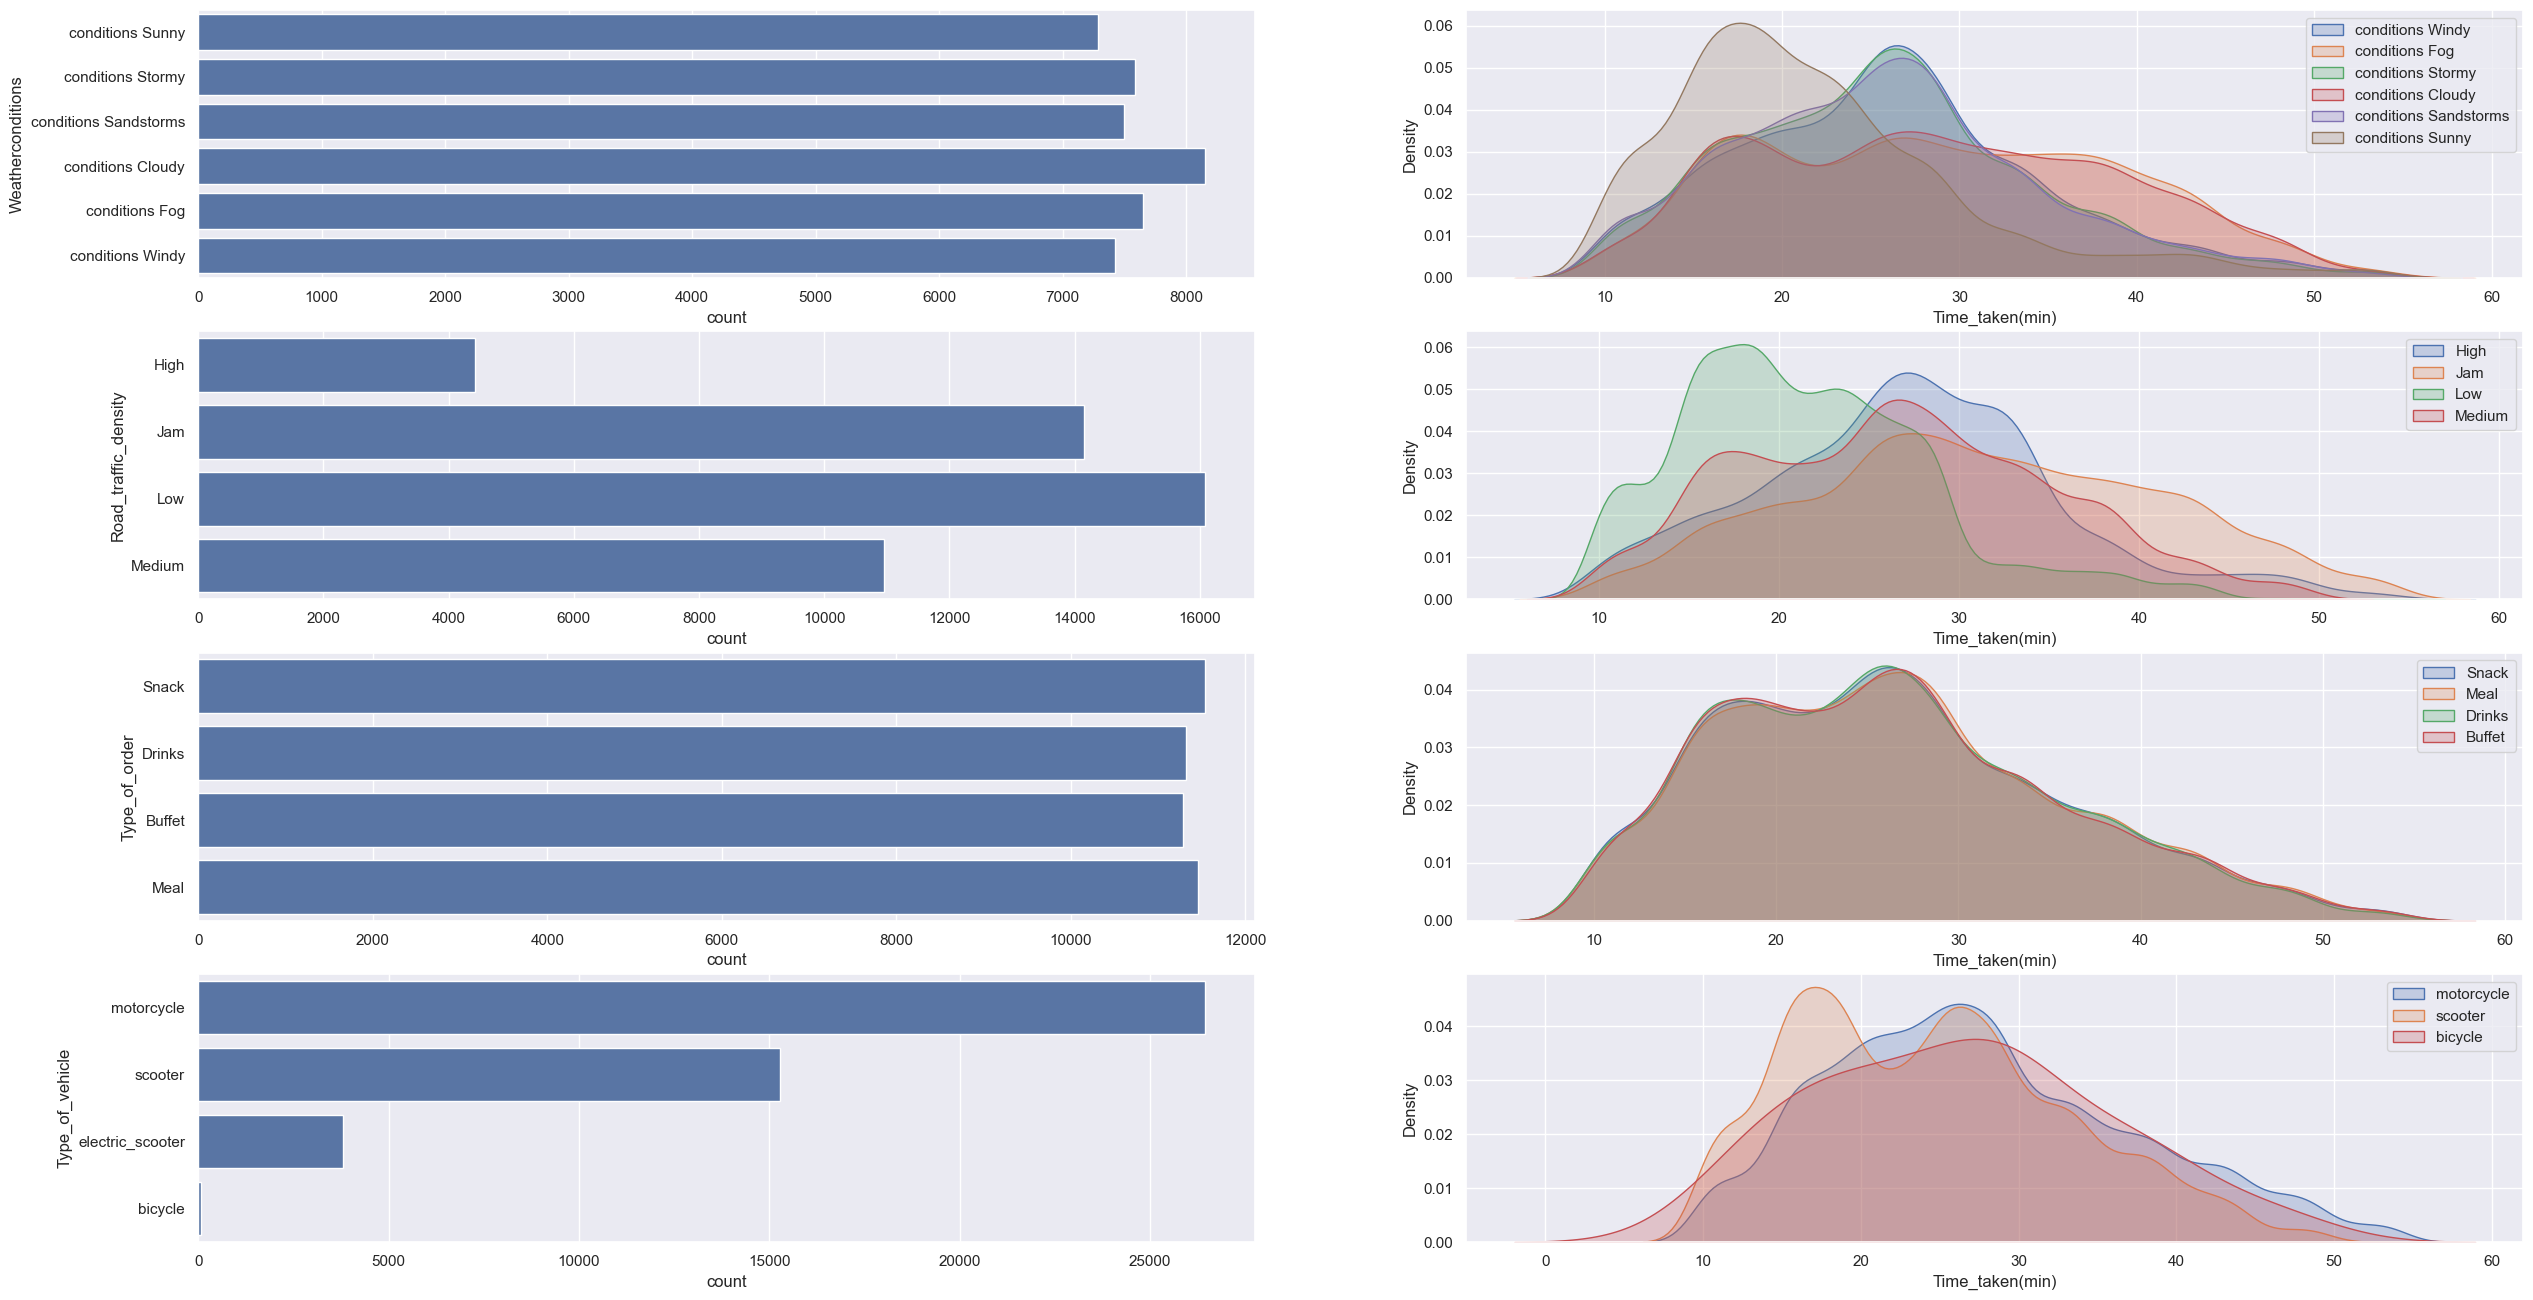

In [26]:
#weatherconditions

plt.subplot(4,2,1)
sns.countplot(df4['Weatherconditions'])

plt.subplot(4,2,2)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Windy']['Time_taken(min)'], label = 'conditions Windy', fill = True)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Fog']['Time_taken(min)'], label = 'conditions Fog', fill = True)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Stormy']['Time_taken(min)'], label = 'conditions Stormy', fill = True)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Cloudy']['Time_taken(min)'], label = 'conditions Cloudy', fill = True)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Sandstorms']['Time_taken(min)'], label = 'conditions Sandstorms', fill = True)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Sunny']['Time_taken(min)'], label = 'conditions Sunny', fill = True)

plt.legend()

#road traffic density

plt.subplot(4,2,3)
sns.countplot(df4['Road_traffic_density'])

plt.subplot(4,2,4)
sns.kdeplot(df4[df4['Road_traffic_density'] == 'High']['Time_taken(min)'], label = 'High', fill = True)
sns.kdeplot(df4[df4['Road_traffic_density'] == 'Jam']['Time_taken(min)'], label = 'Jam', fill = True)
sns.kdeplot(df4[df4['Road_traffic_density'] == 'Low']['Time_taken(min)'], label = 'Low', fill = True)
sns.kdeplot(df4[df4['Road_traffic_density'] == 'Medium']['Time_taken(min)'], label = 'Medium', fill = True)

plt.legend()

#type of order

plt.subplot(4,2,5)
sns.countplot(df4['Type_of_order'])

plt.subplot(4,2,6)
sns.kdeplot(df4[df4['Type_of_order'] == 'Snack']['Time_taken(min)'], label = 'Snack', fill = True)
sns.kdeplot(df4[df4['Type_of_order'] == 'Meal']['Time_taken(min)'], label = 'Meal', fill = True)
sns.kdeplot(df4[df4['Type_of_order'] == 'Drinks']['Time_taken(min)'], label = 'Drinks', fill = True)
sns.kdeplot(df4[df4['Type_of_order'] == 'Buffet']['Time_taken(min)'], label = 'Buffet', fill = True)

plt.legend()

#type of order

plt.subplot(4,2,7)
sns.countplot(df4['Type_of_vehicle'])

plt.subplot(4,2,8)
sns.kdeplot(df4[df4['Type_of_vehicle'] == 'motorcycle']['Time_taken(min)'], label = 'motorcycle', fill = True)
sns.kdeplot(df4[df4['Type_of_vehicle'] == 'scooter']['Time_taken(min)'], label = 'scooter', fill = True)
sns.kdeplot(df4[df4['Type_of_vehicle'] == 'eletric_scooter']['Time_taken(min)'], label = 'eletric_scooter', fill = True)
sns.kdeplot(df4[df4['Type_of_vehicle'] == 'bicycle']['Time_taken(min)'], label = 'bicycle', fill = True)

plt.legend()

### 4.2 Análise Bivariada

#### Hipótese 1: Quanto maior o tempo de preparo do pedido maior o tempo de entrega: 
FALSA. Não há relação.

<Axes: >

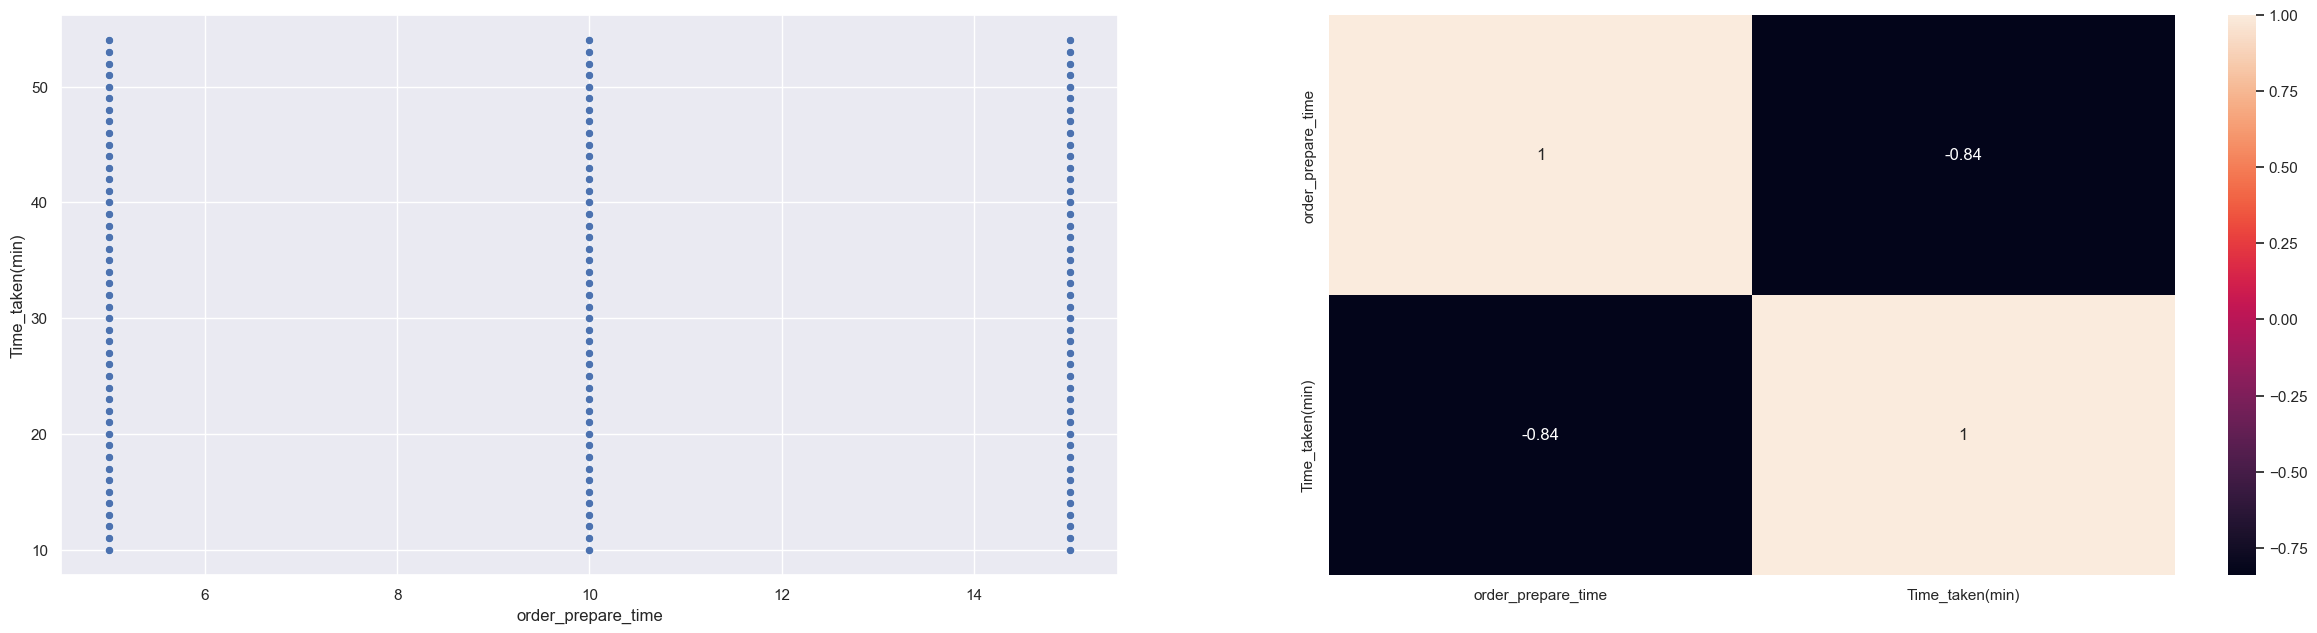

In [59]:
aux1 = df4[['order_prepare_time', 'Time_taken(min)']].groupby('order_prepare_time').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[0,0])
sns.scatterplot(x = 'order_prepare_time', y = 'Time_taken(min)', data = df4)

plt.subplot(grid[0,1])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

#### Hipótese 2: Quanto maior a distância entre o restaurante e o cliente maior o tempo de entrega:
FALSA. Não há relação entre a distância e o tempo de entrega

<Axes: >

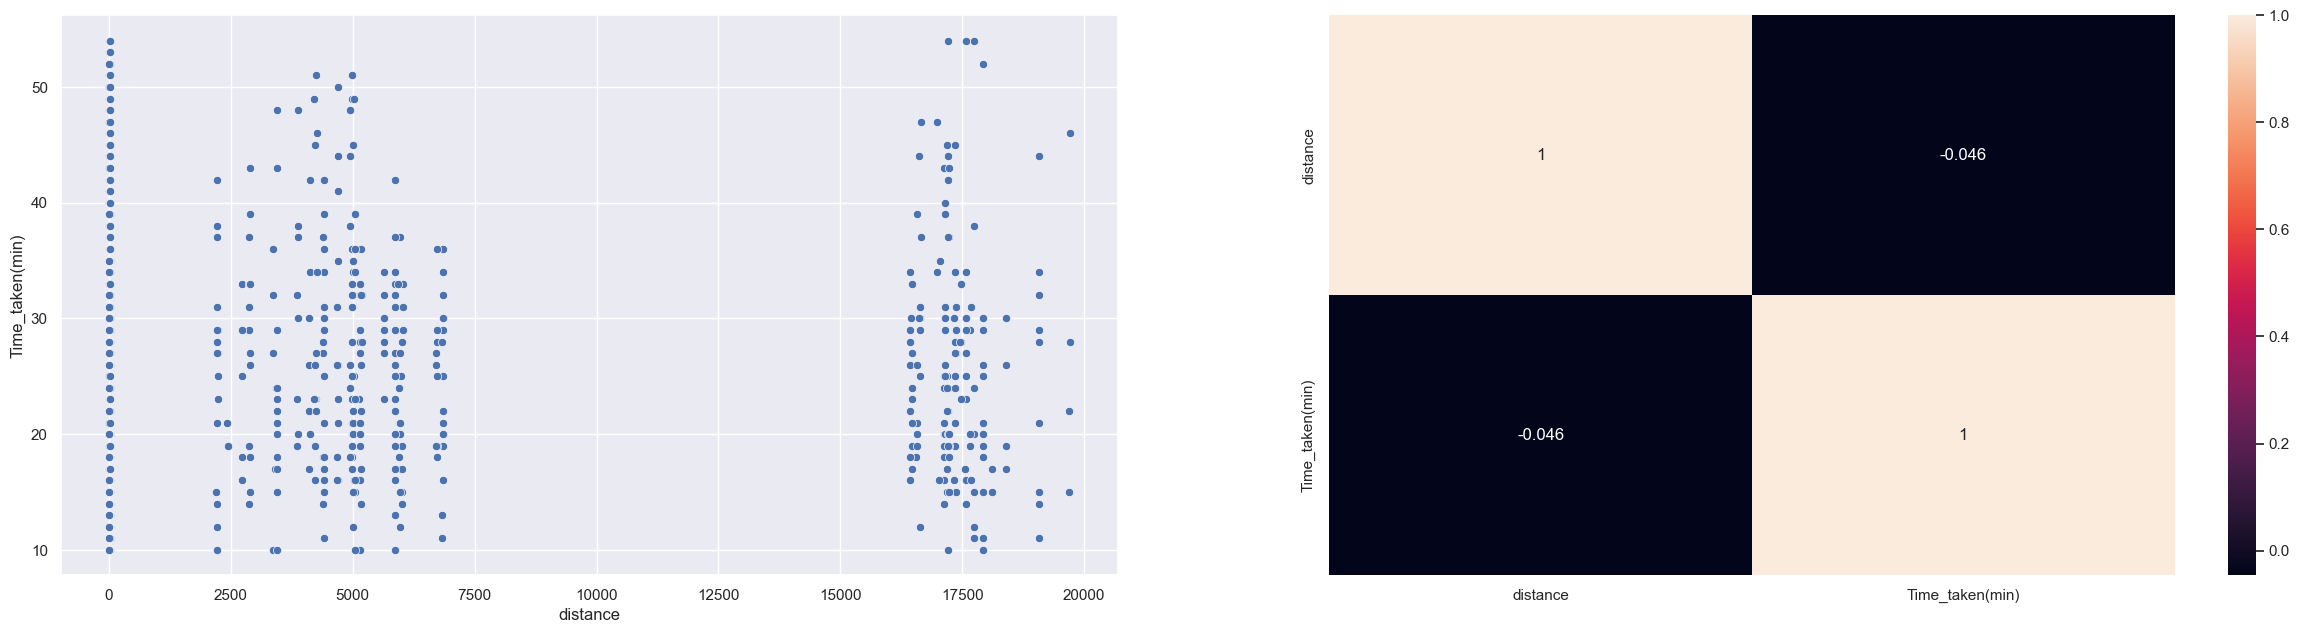

In [60]:
aux2 = df4[['distance', 'Time_taken(min)']].groupby('distance').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[0,0])
sns.scatterplot(x = 'distance', y = 'Time_taken(min)', data = df4)

plt.subplot(grid[0,1])
sns.heatmap(aux2.corr(method = 'pearson'), annot = True)

#### Hipótese 3: Pedidos aos finais de semana possuem maior tempo de entrega
FALSA:  a média do tempo de entrega é menor aos finais de semana



<Axes: xlabel='is_weekend', ylabel='Time_taken(min)'>

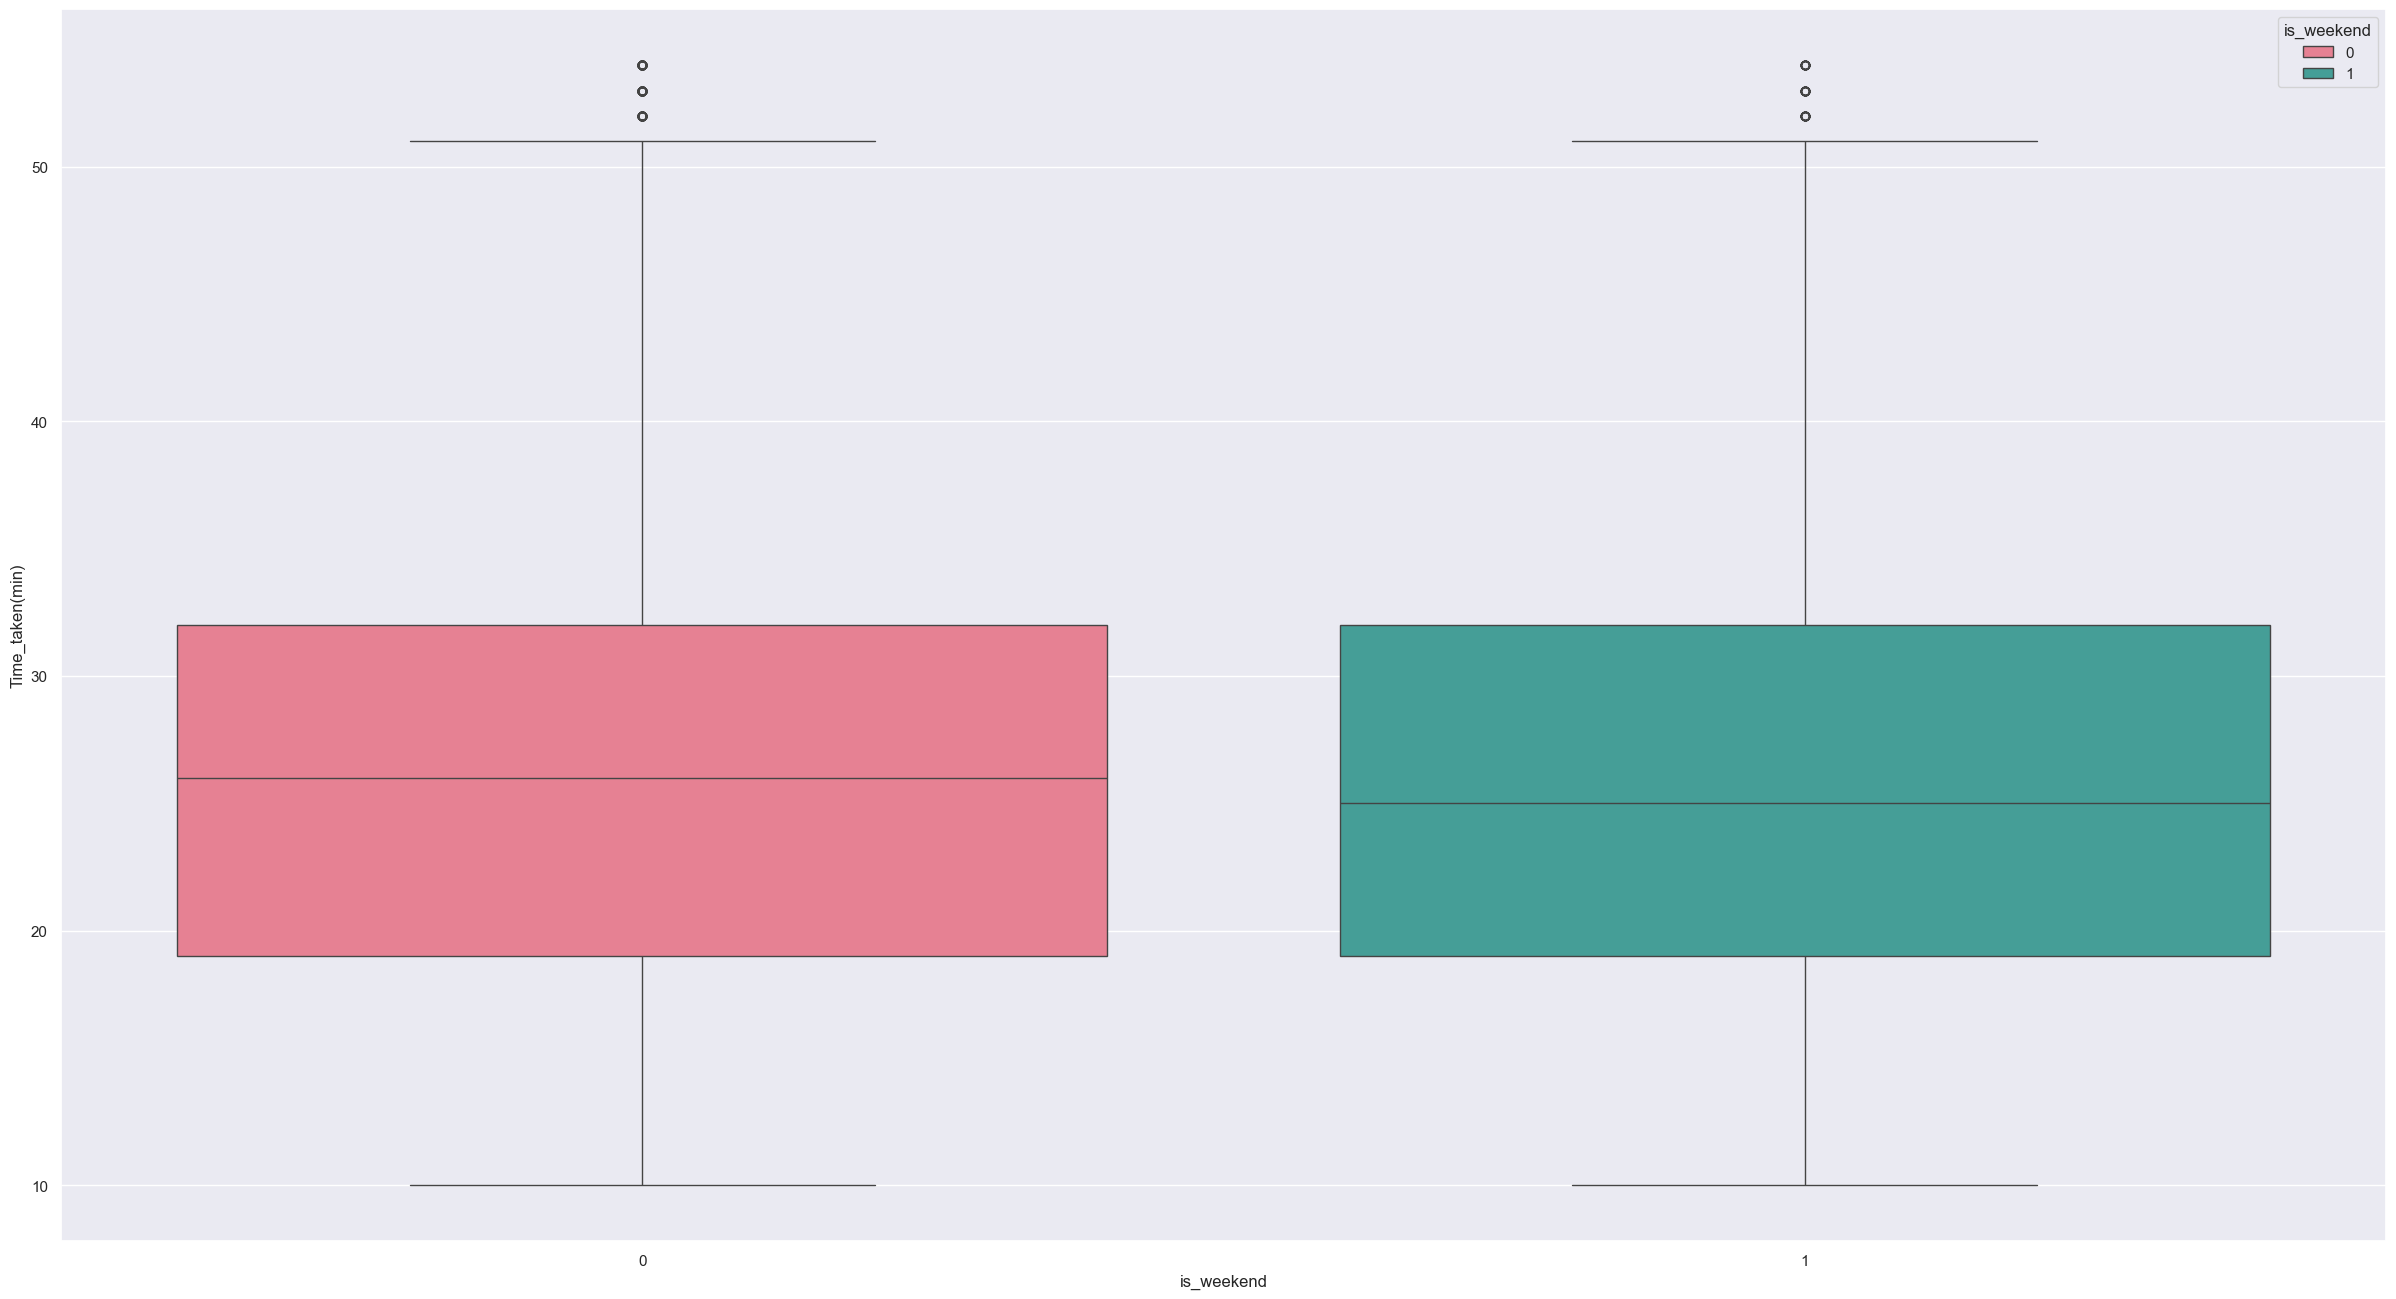

In [61]:
sns.boxplot(x = 'is_weekend' , y = 'Time_taken(min)' , data = df4, palette = 'husl', hue = 'is_weekend')

#### Hipótese 4: Pedidos no começo do mês possuem maior tempo de entrega
FALSA: o tempo é menor



<Axes: xlabel='is_month_start', ylabel='Time_taken(min)'>

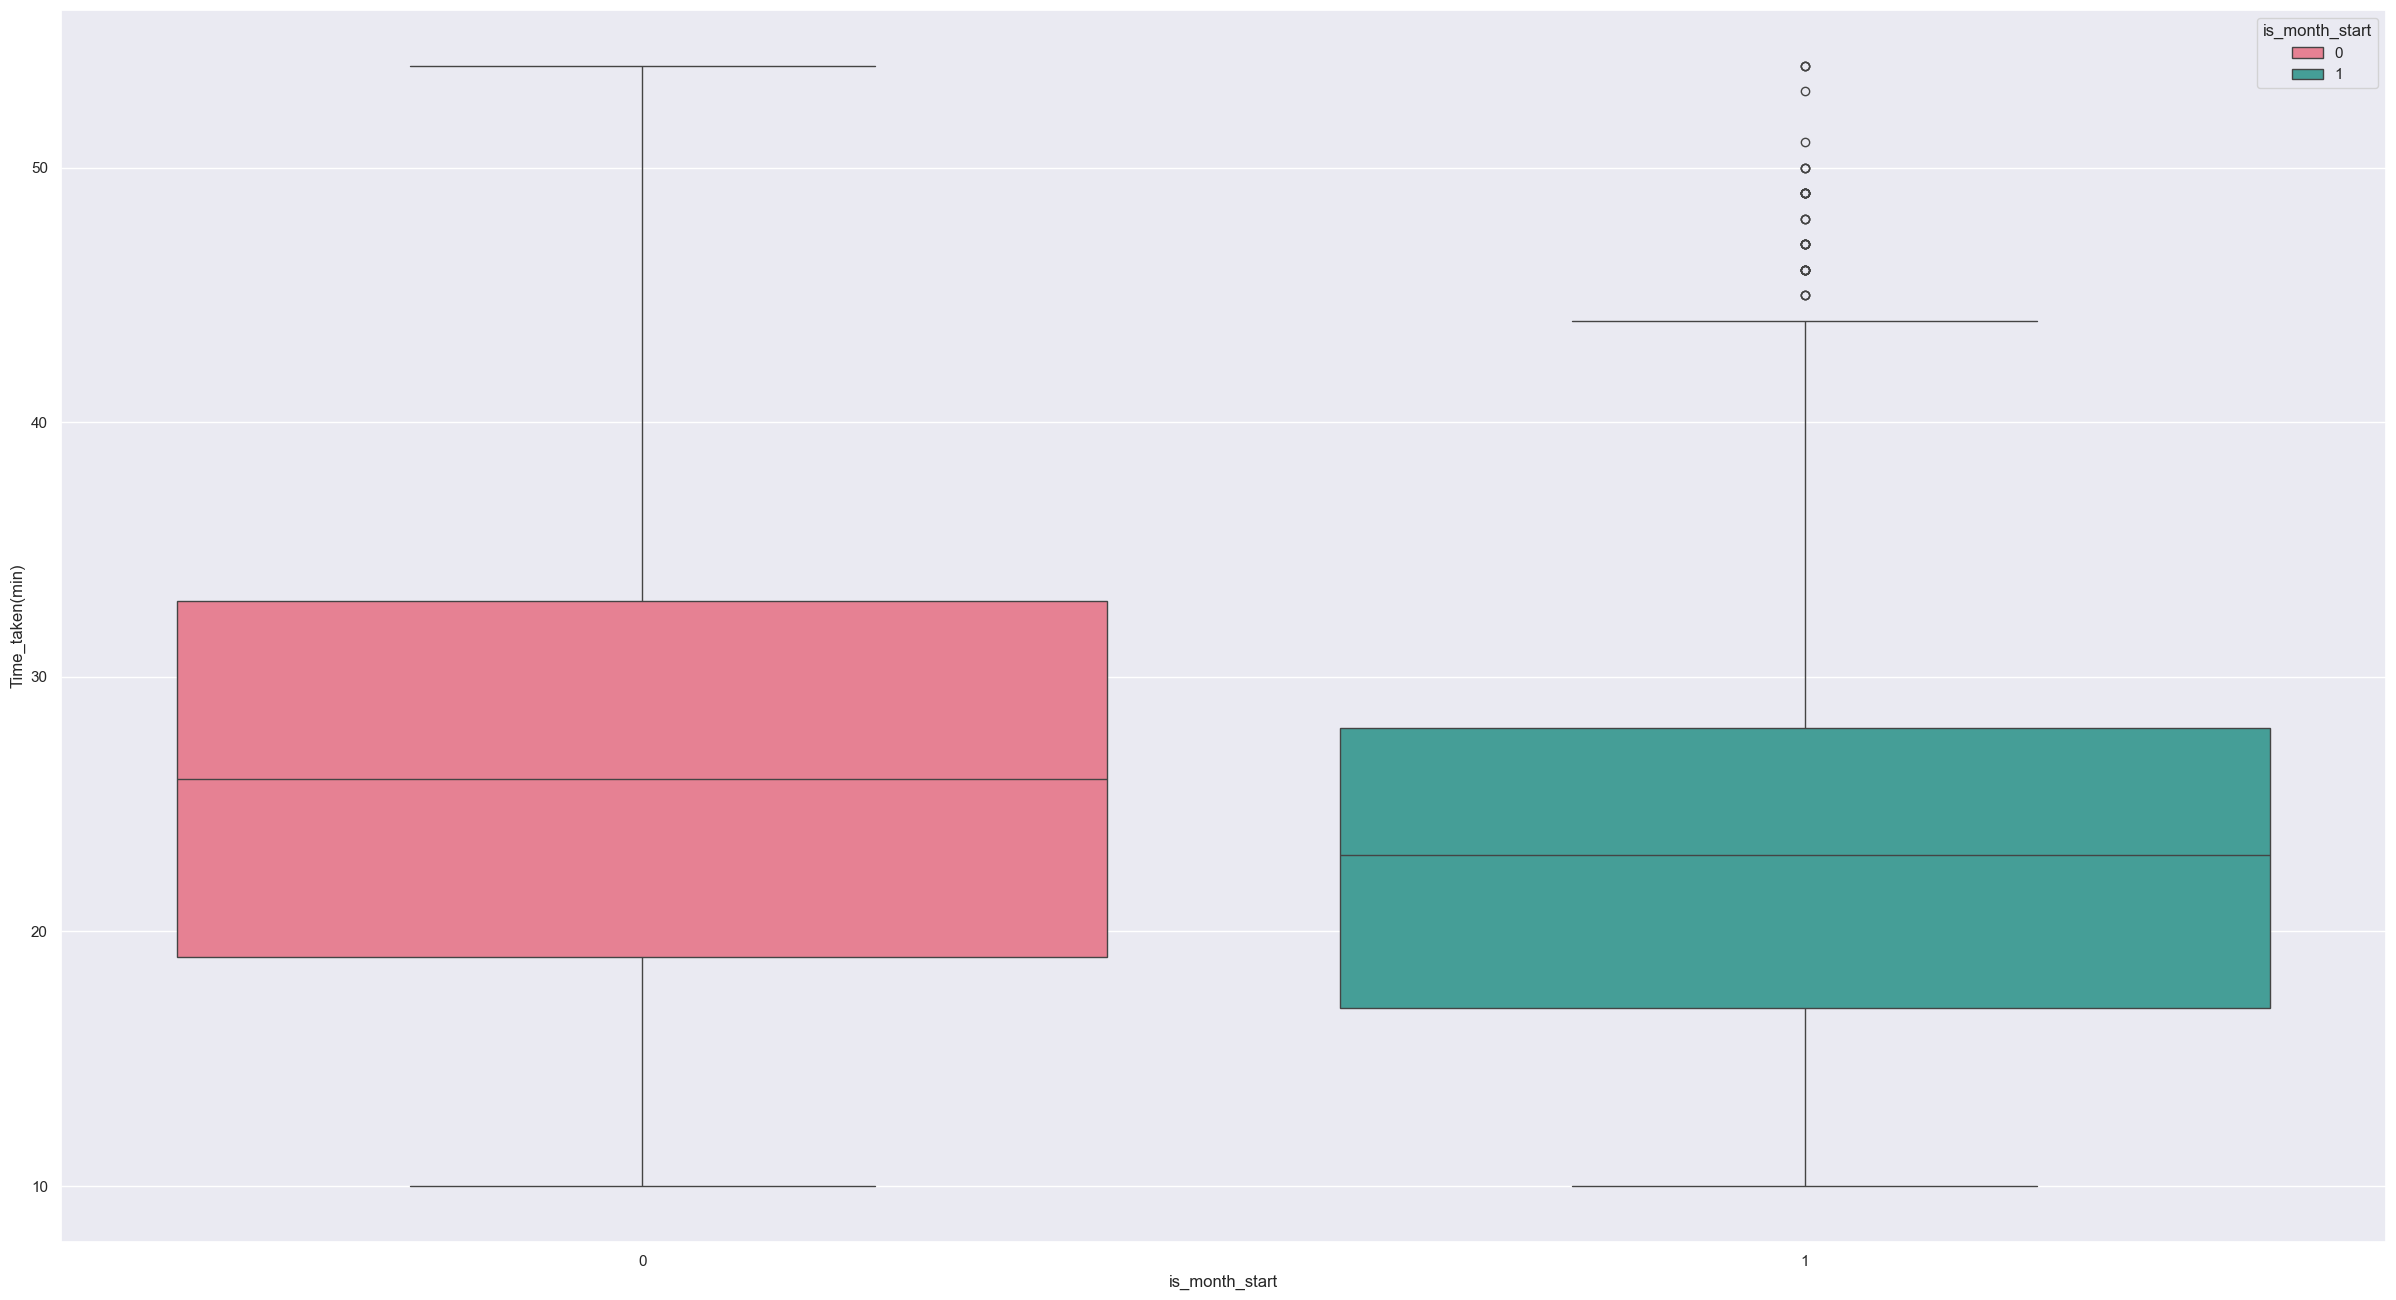

In [62]:
sns.boxplot(x = 'is_month_start' , y = 'Time_taken(min)' , data = df4, palette = 'husl', hue = 'is_month_start')

#### Hipótese 5: Tipos específicos de pedidos podem exigir diferentes tempos de entrega
FALSA. Há pouca diferença do tempo de entrega entre os tipos de pedido

<Axes: xlabel='Type_of_order', ylabel='Time_taken(min)'>

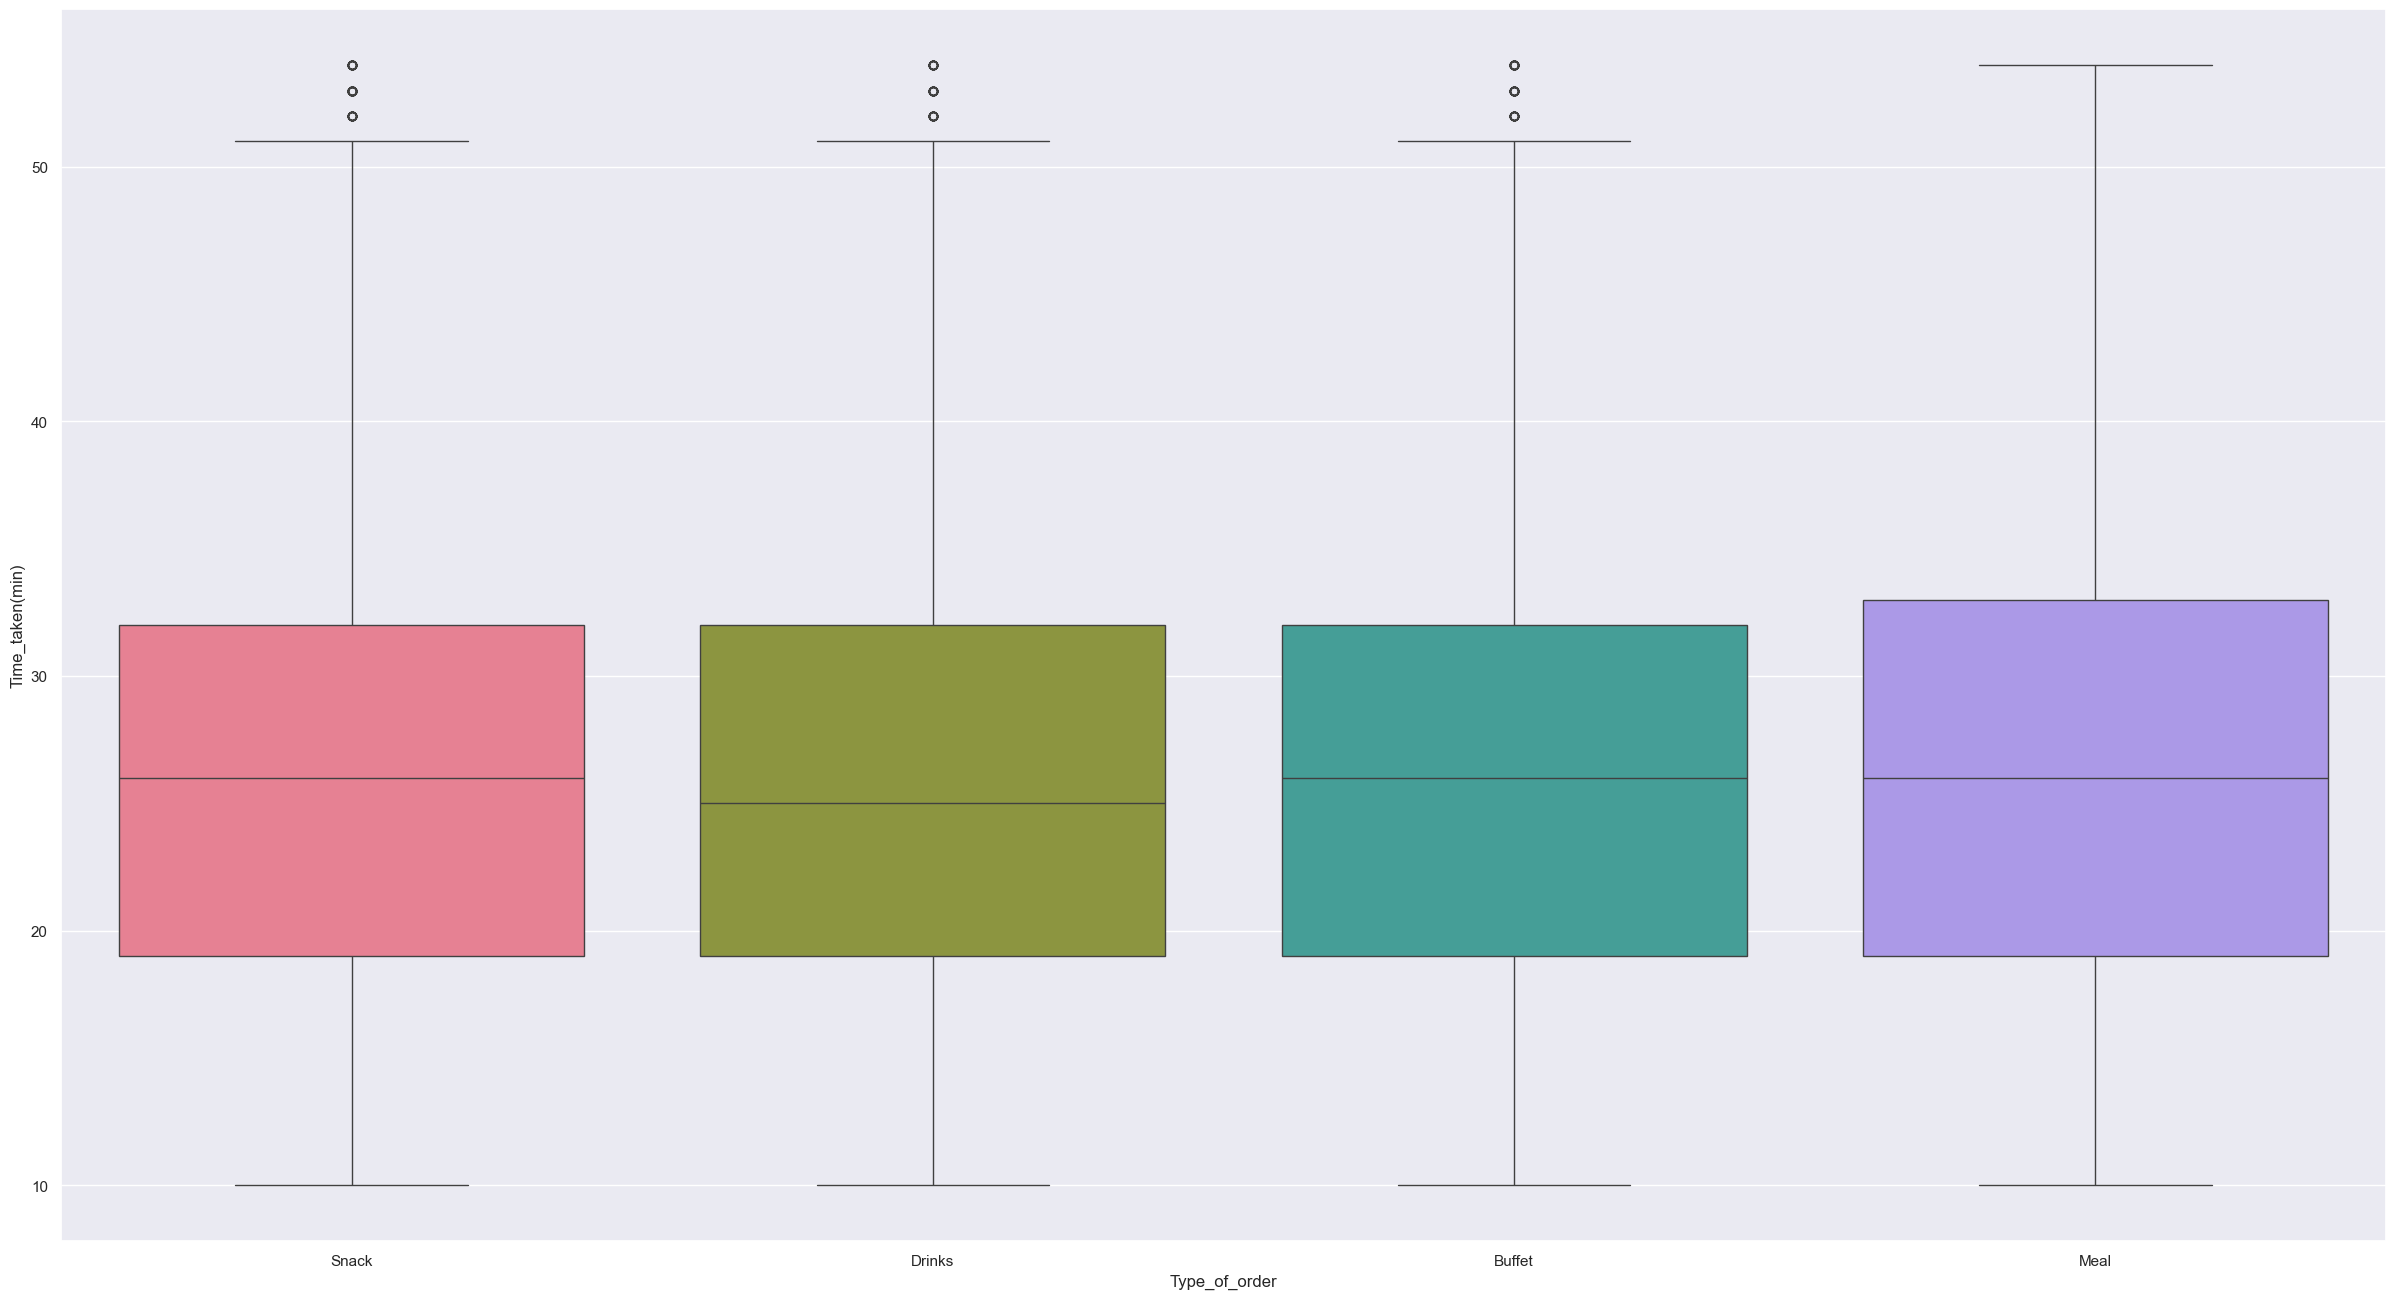

In [63]:
sns.boxplot(x = 'Type_of_order', y = 'Time_taken(min)', data = df4, palette = 'husl', hue = 'Type_of_order')

#### Hipótese 6: A idade do entregador afeta a velocidade da entrega
FALSA. Não há relação entre a idade e o tempo de entrega

<Axes: >

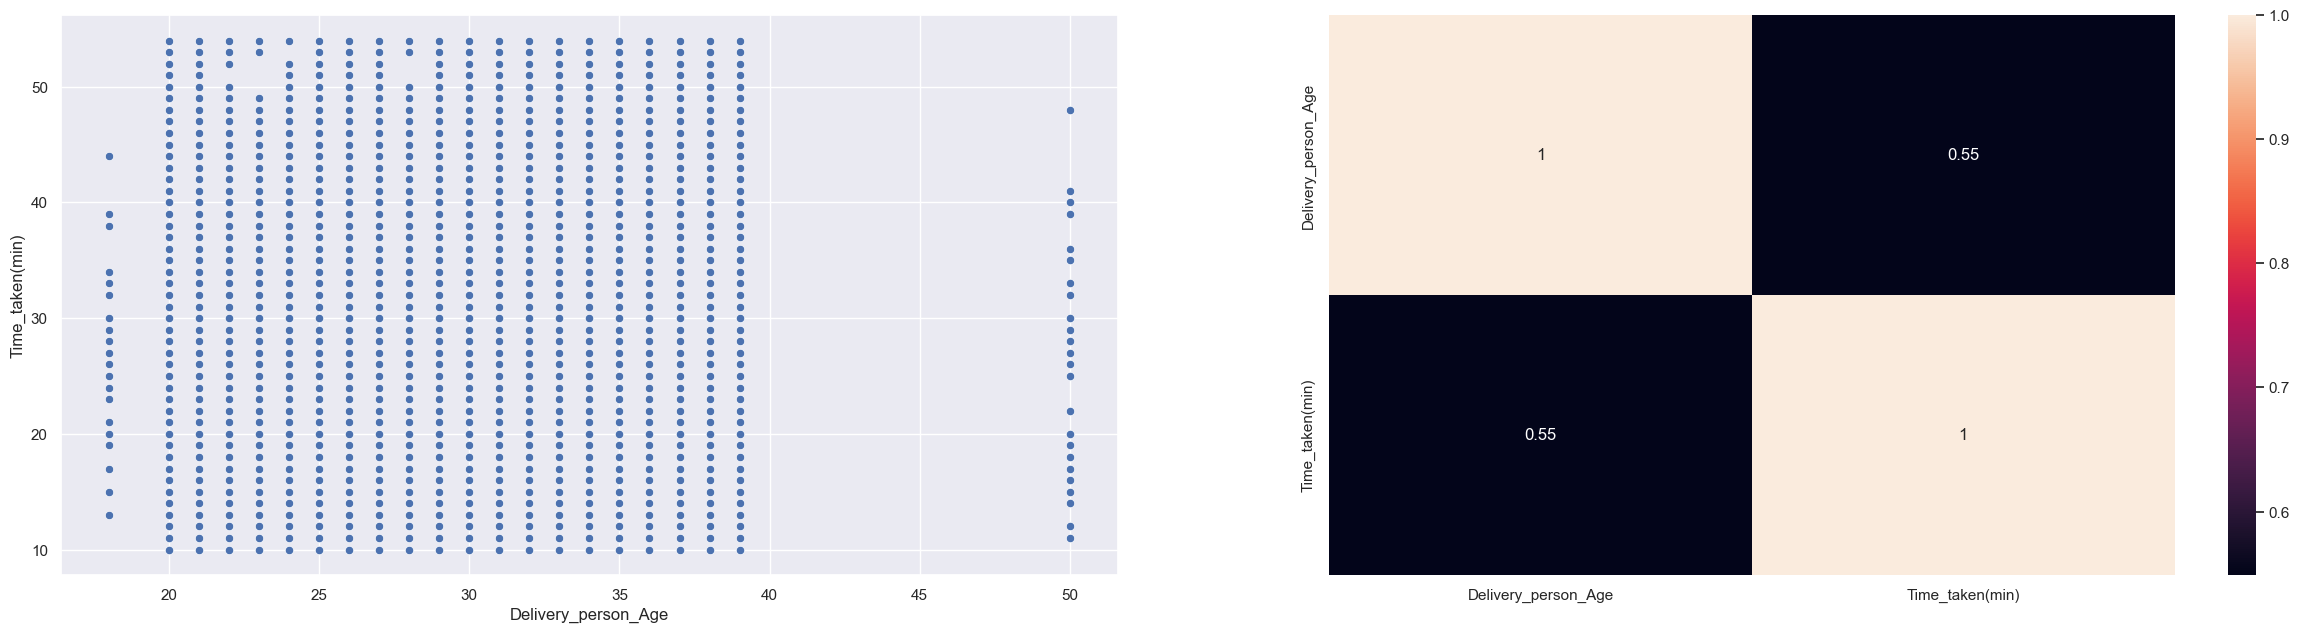

In [64]:
aux6 = df4[['Delivery_person_Age', 'Time_taken(min)']].groupby('Delivery_person_Age').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[0,0])
sns.scatterplot(x = 'Delivery_person_Age', y = 'Time_taken(min)', data = df4)

plt.subplot(grid[0,1])
sns.heatmap(aux6.corr(method = 'pearson'), annot = True)


#### Hipótese 7: Avaliações do entregador podem impactar a eficiência da entrega
VERDADEIRA. A média do tempo de entrega varia conforme o rating do entregador.

<Axes: xlabel='Delivery_person_Ratings', ylabel='Time_taken(min)'>

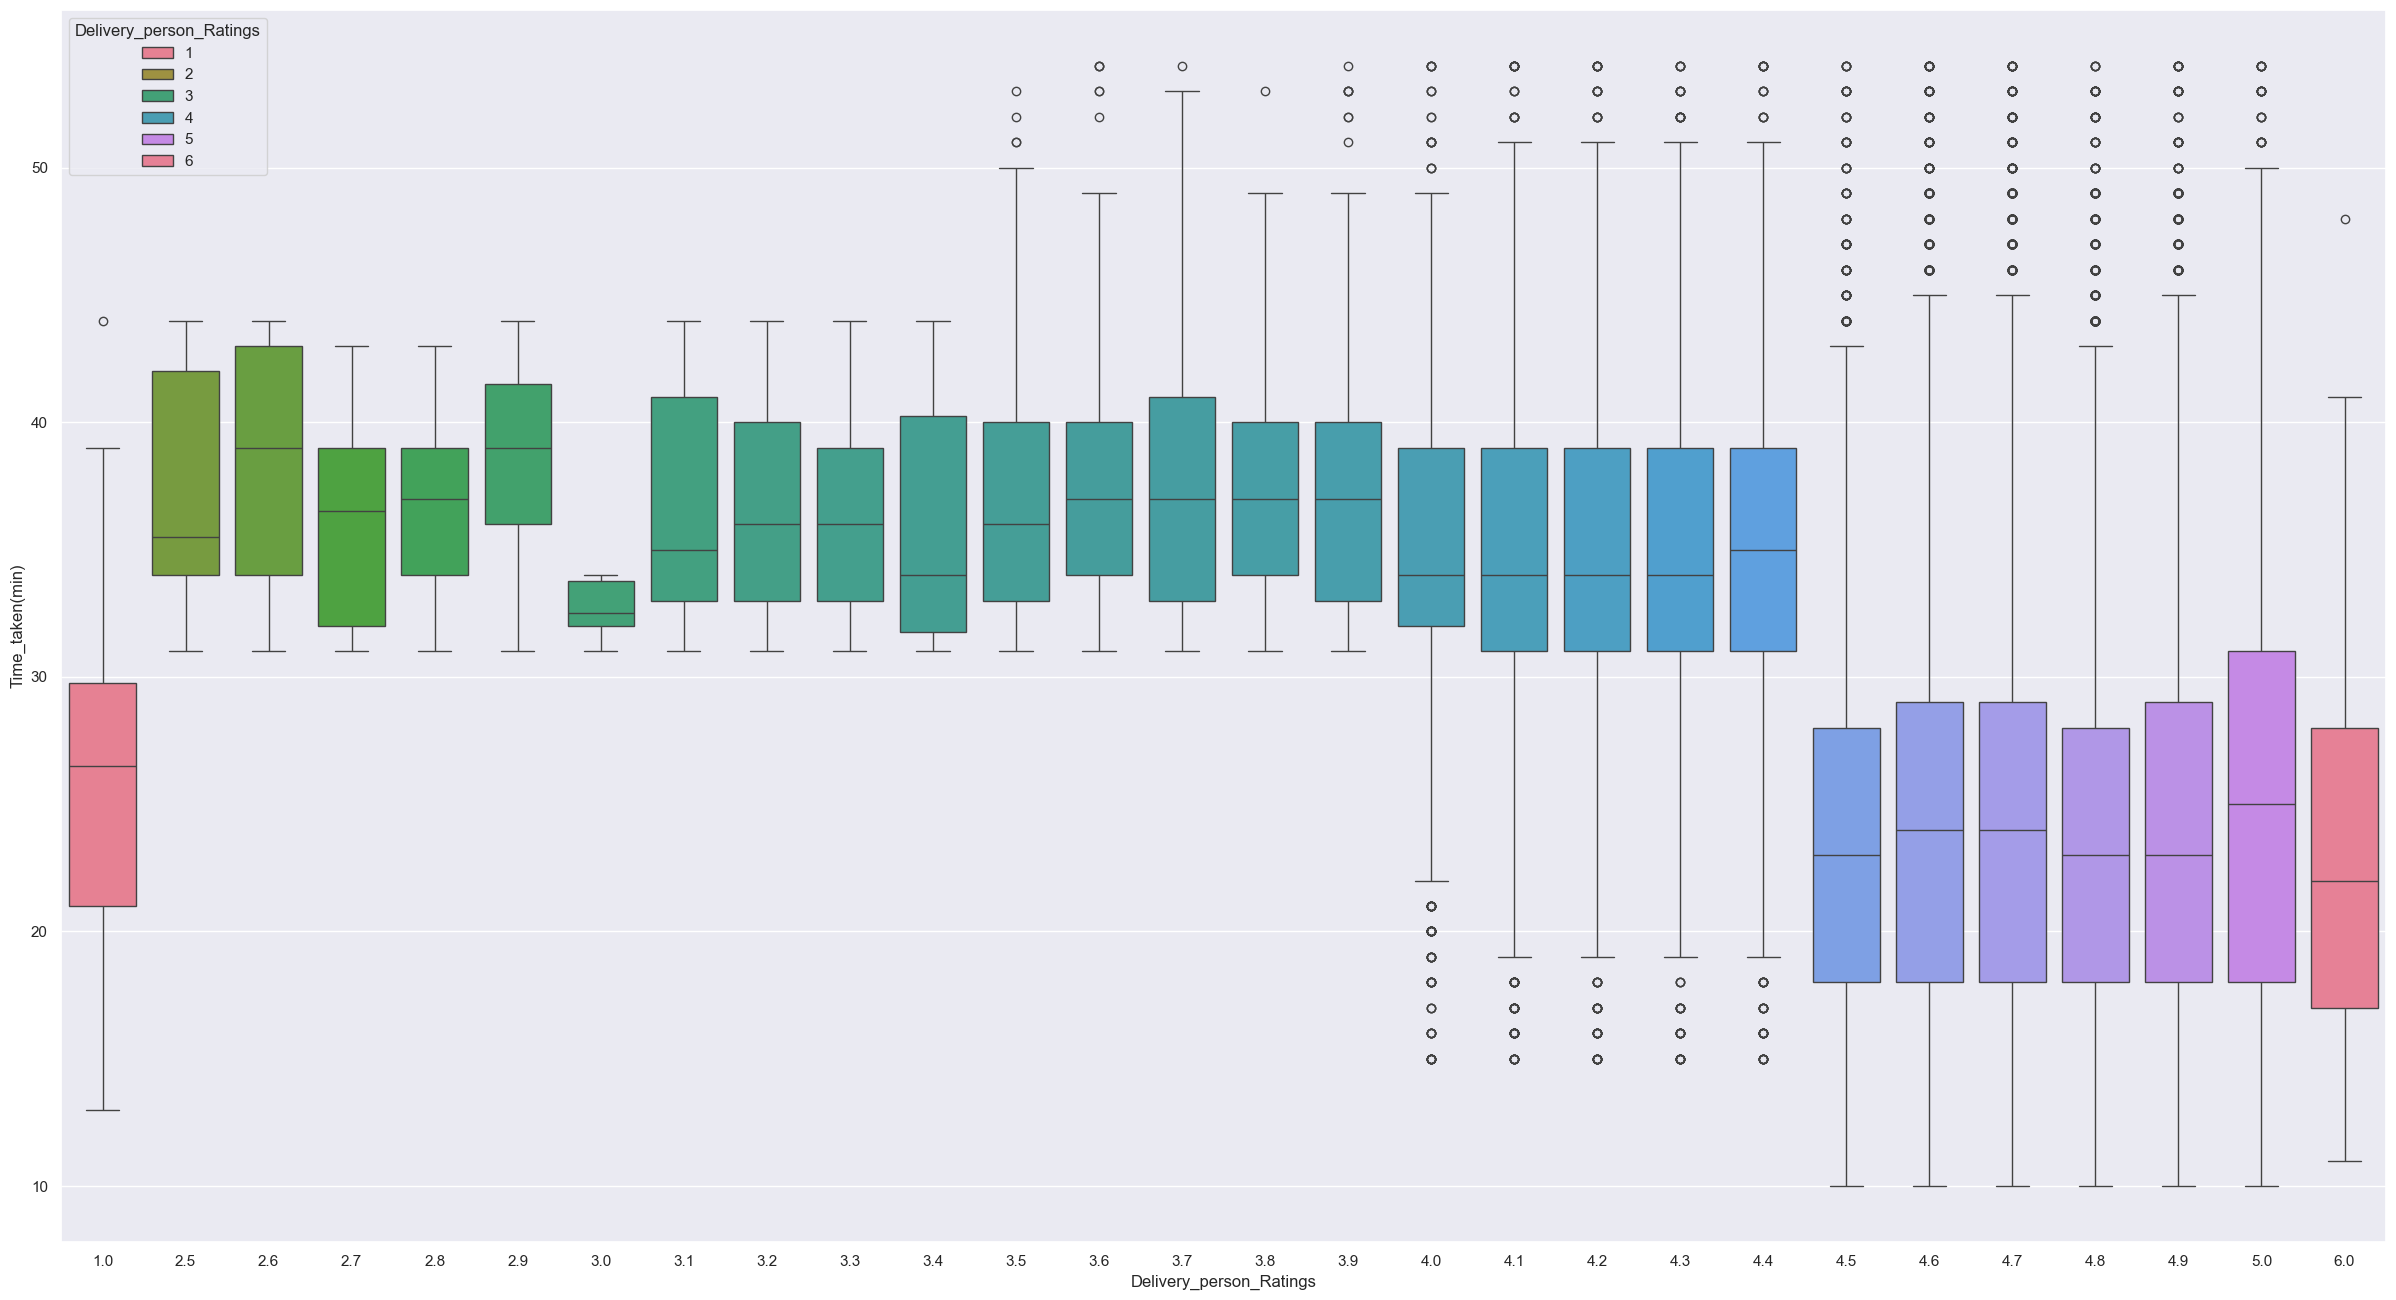

In [65]:
sns.boxplot(x='Delivery_person_Ratings', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Delivery_person_Ratings')

#### Hipótese 8: O tipo de veículo usado para a entrega pode impactar no tempo de entrega;
VERDADEIRA


<Axes: xlabel='Type_of_vehicle', ylabel='Time_taken(min)'>

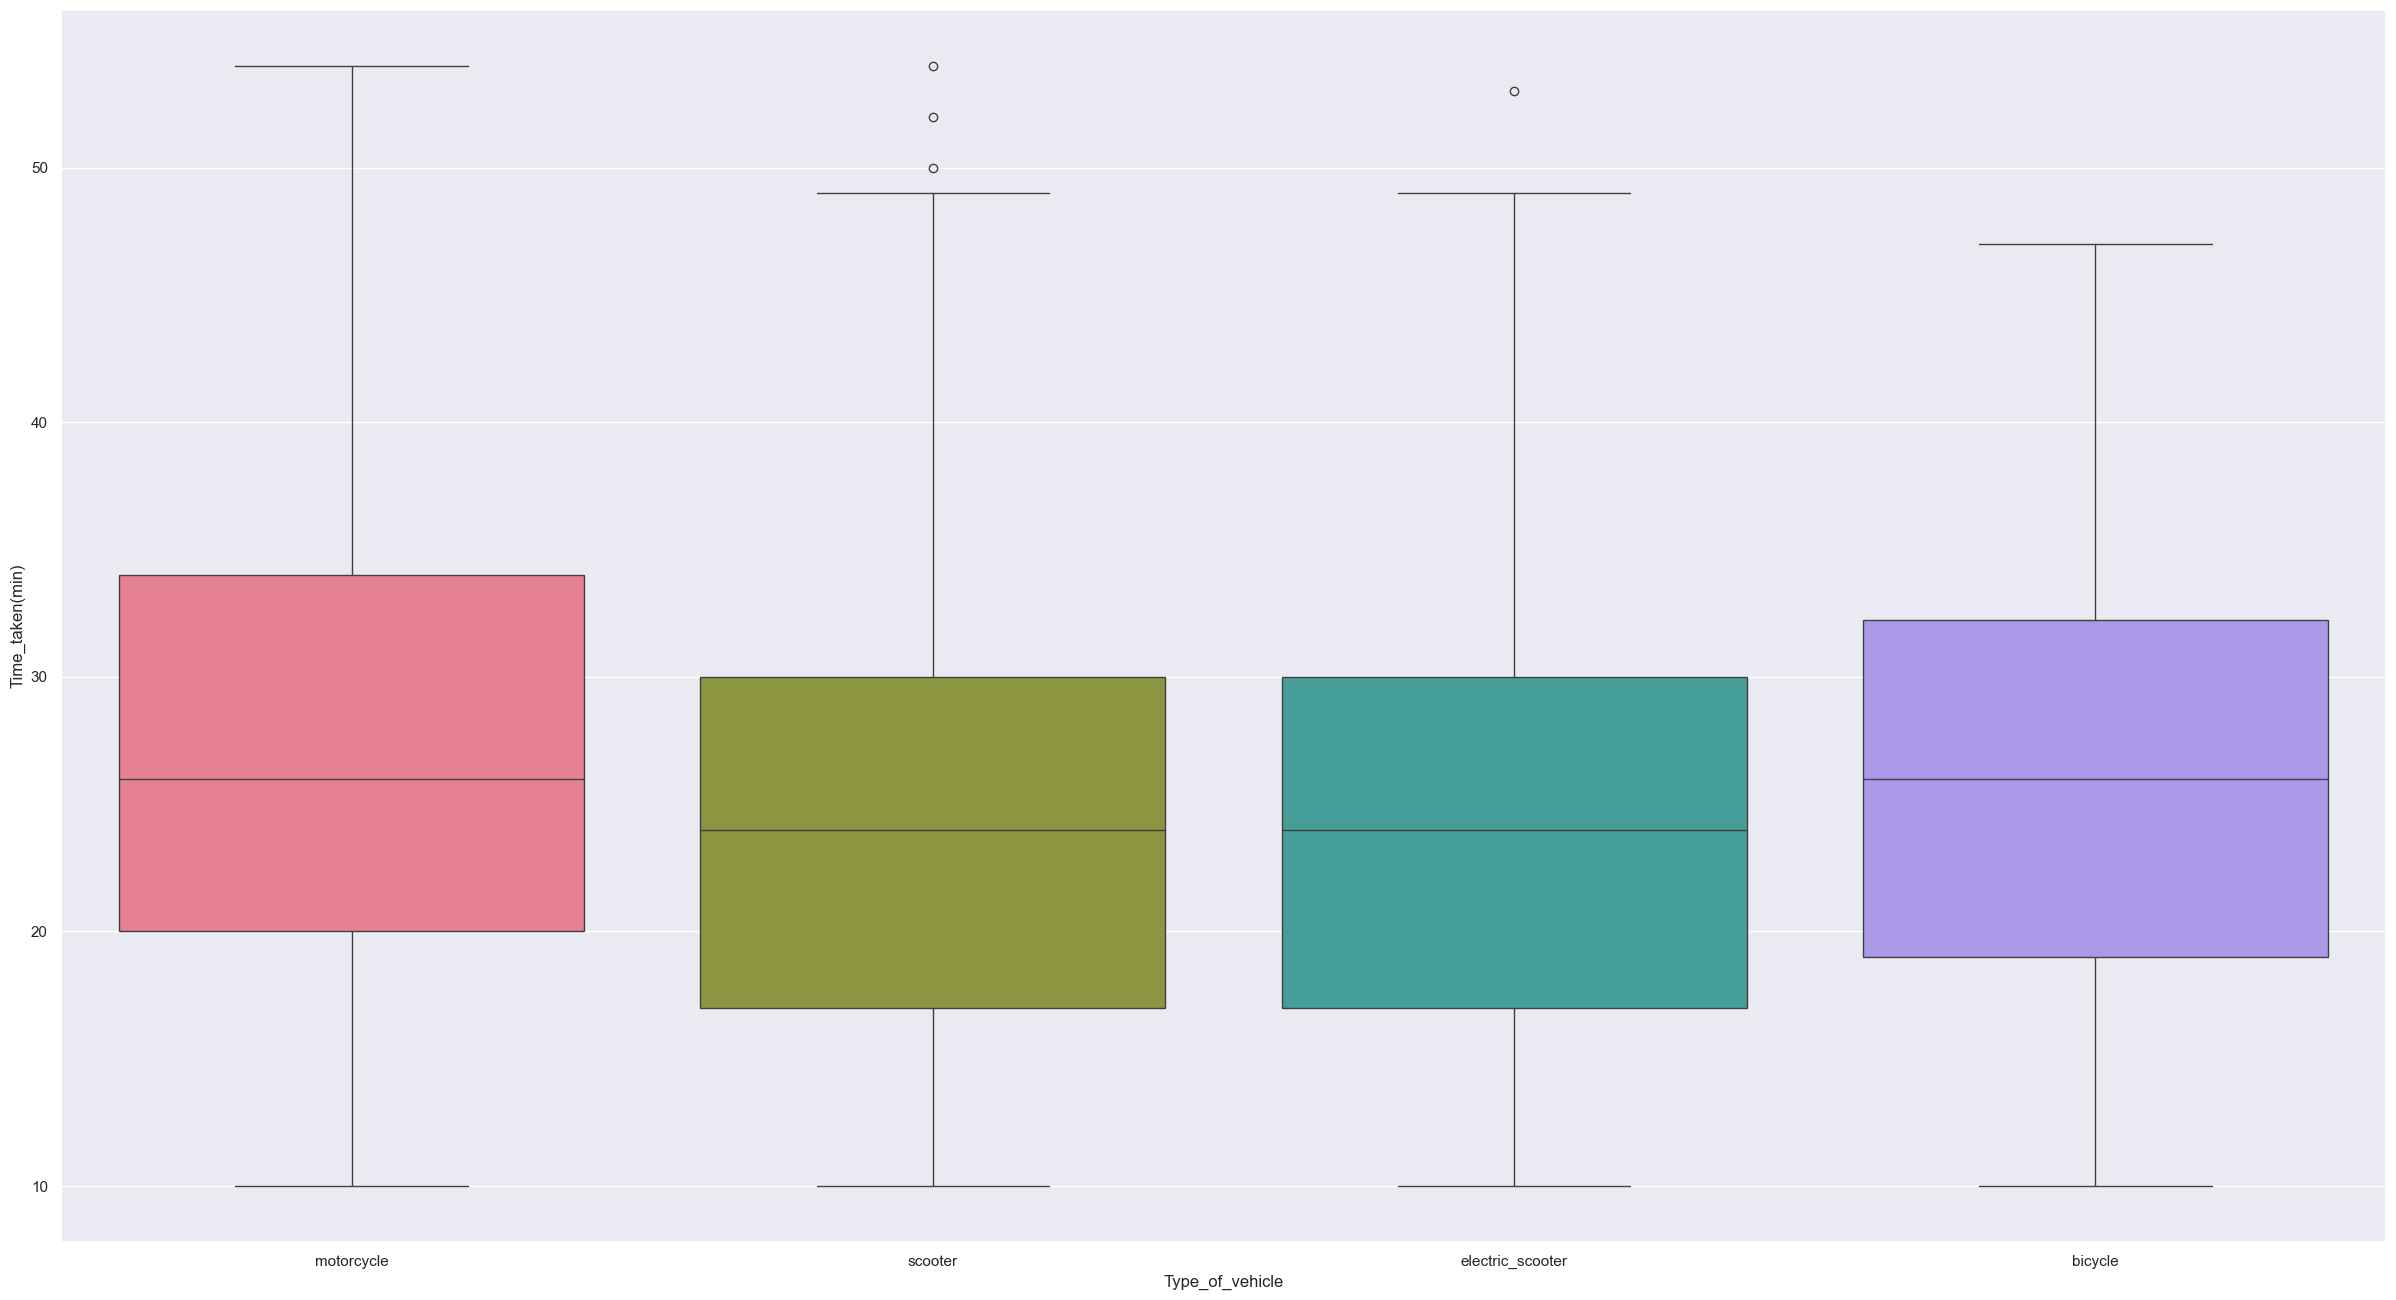

In [66]:
sns.boxplot(x='Type_of_vehicle', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Type_of_vehicle')

#### Hipótese 9: Múltiplas entregas em uma única rota podem aumentar o tempo de entrega
VERDADEIRA

<Axes: xlabel='multiple_deliveries', ylabel='Time_taken(min)'>

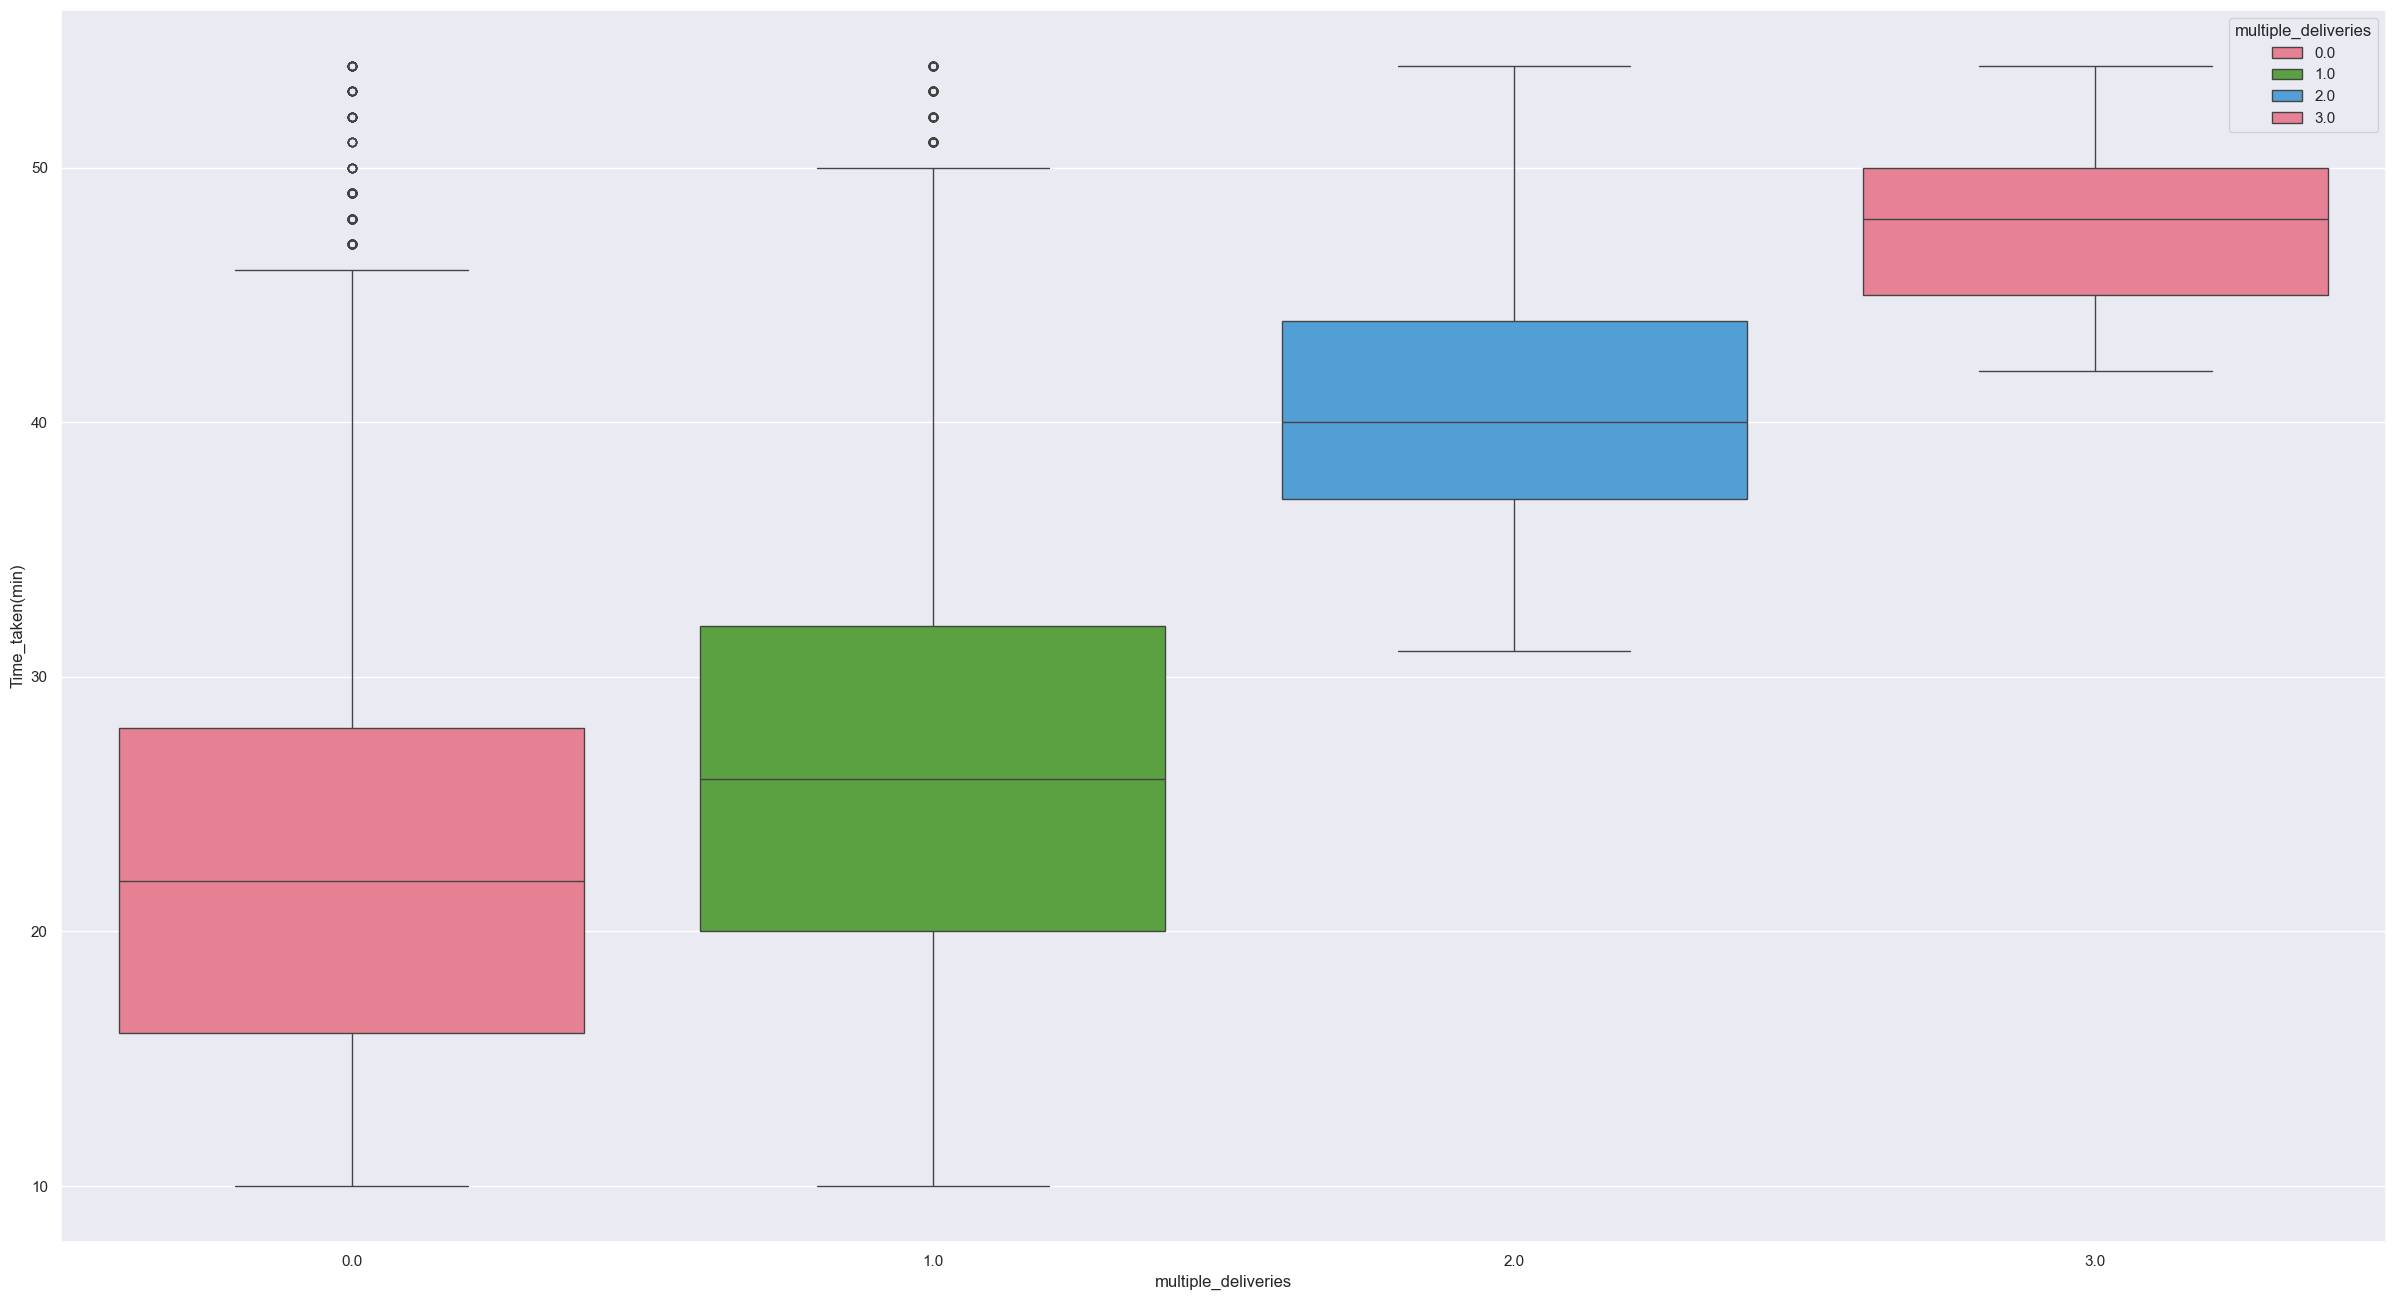

In [67]:
sns.boxplot(x='multiple_deliveries', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'multiple_deliveries')

#### Hipótese 10: A condição do veículo pode influenciar o tempo de entrega
VERDADEIRA

<Axes: xlabel='Vehicle_condition', ylabel='Time_taken(min)'>

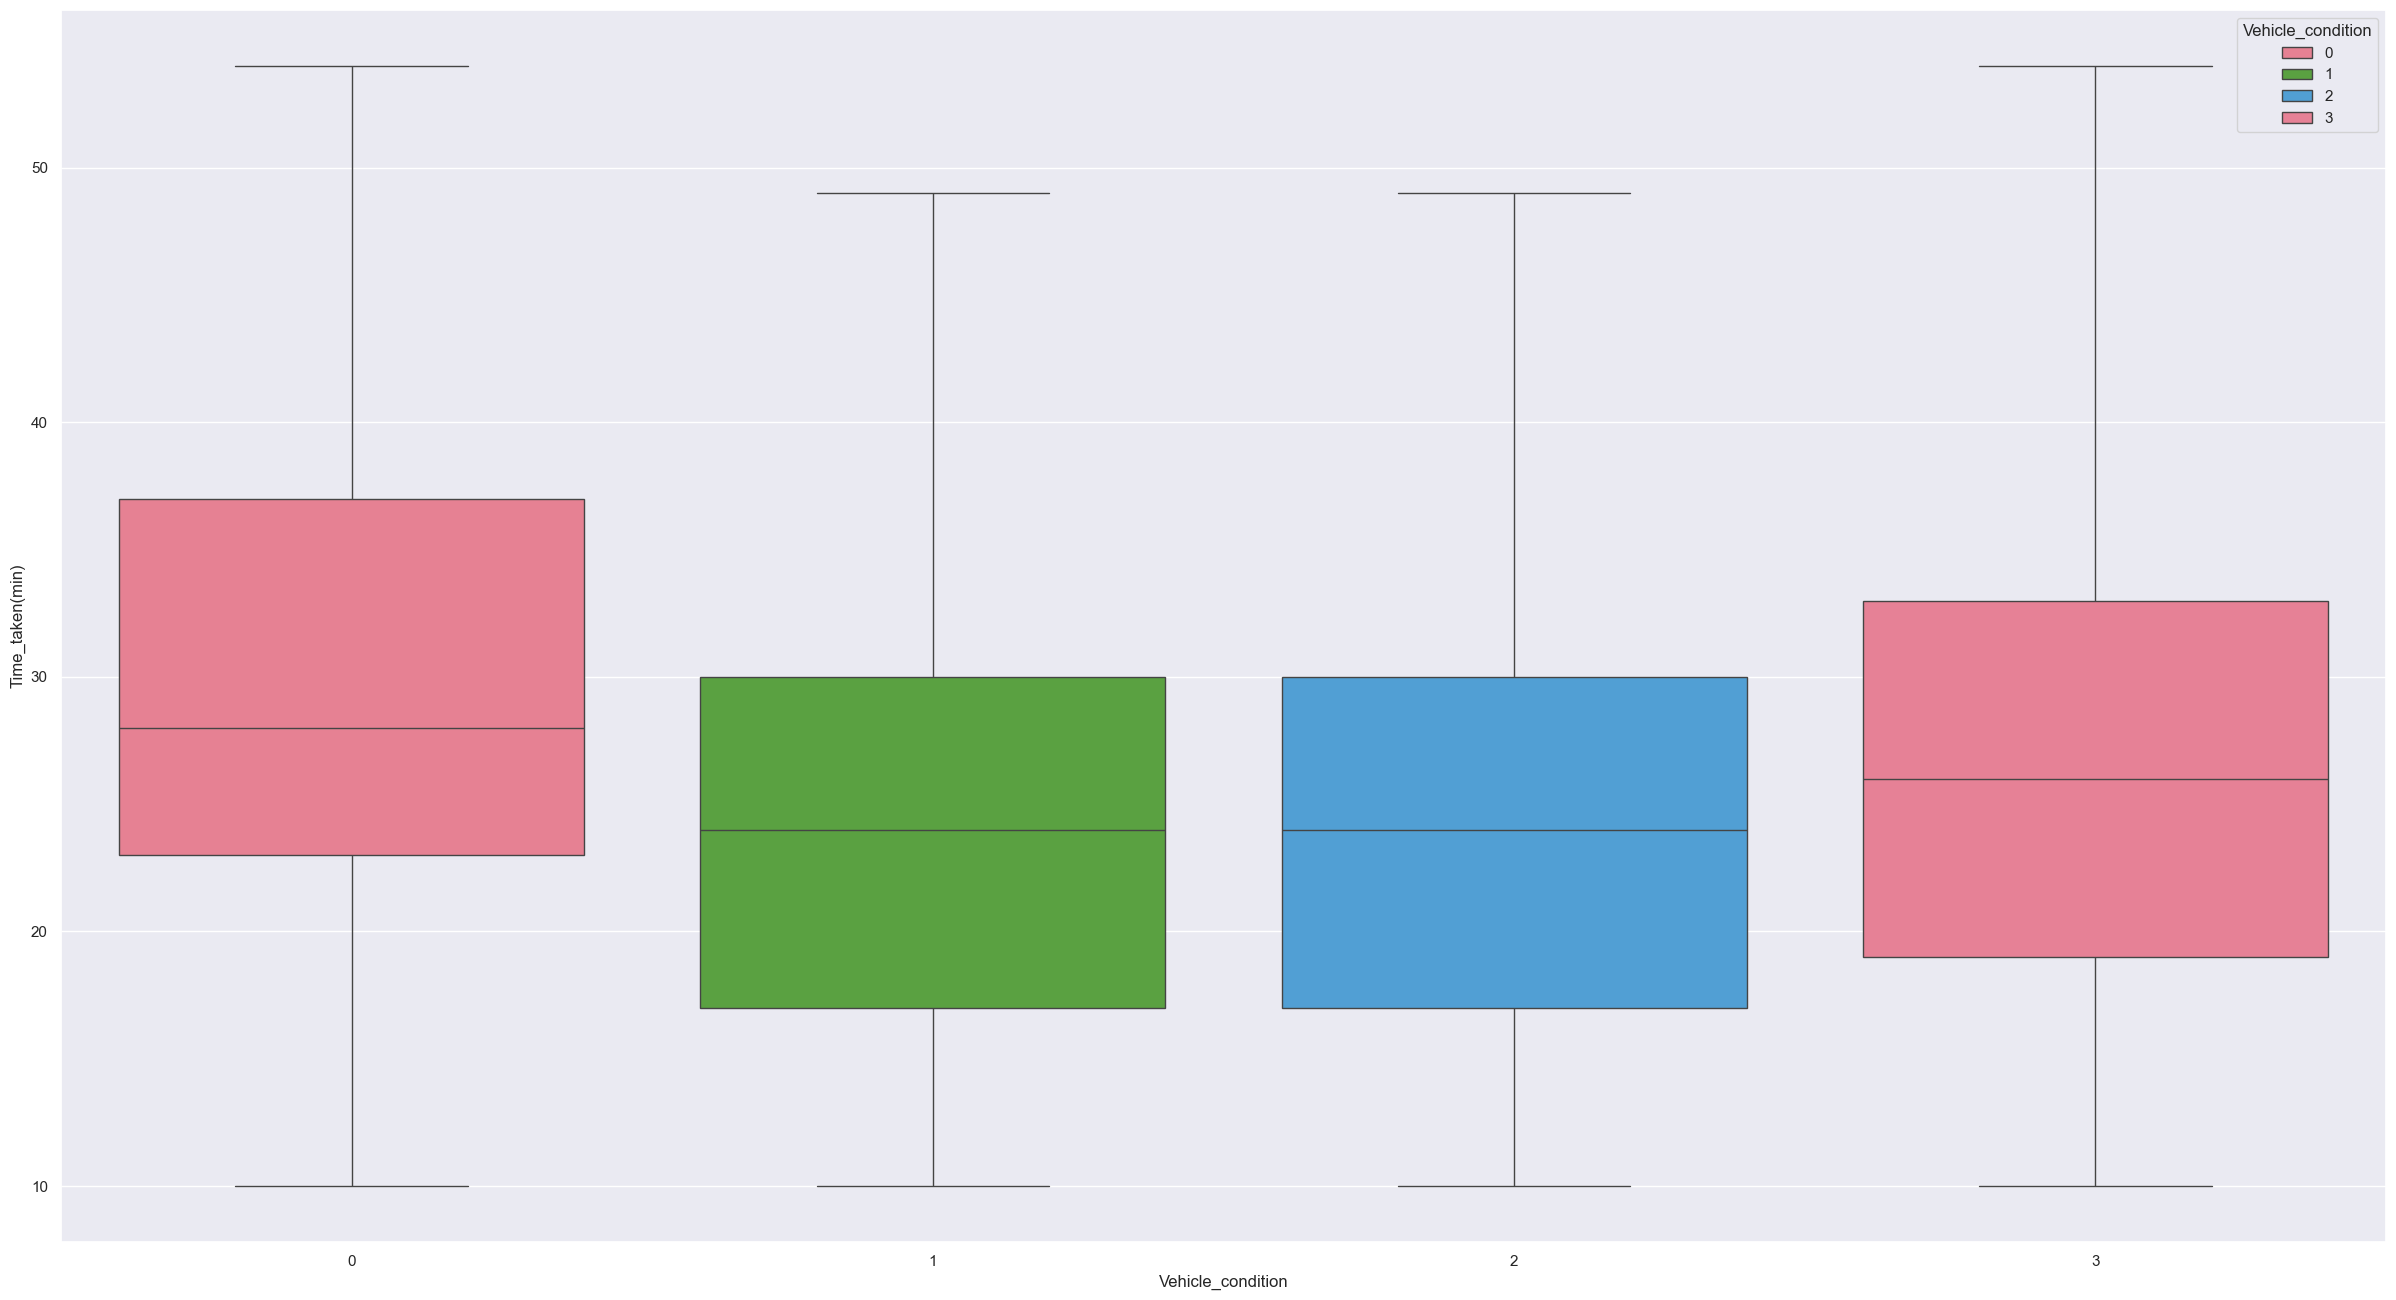

In [68]:
sns.boxplot(x='Vehicle_condition', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Vehicle_condition')

#### Hipótese 11: Condições climáticas adversas podem aumentar o tempo de entrega
VERDADEIRA

<Axes: xlabel='Weatherconditions', ylabel='Time_taken(min)'>

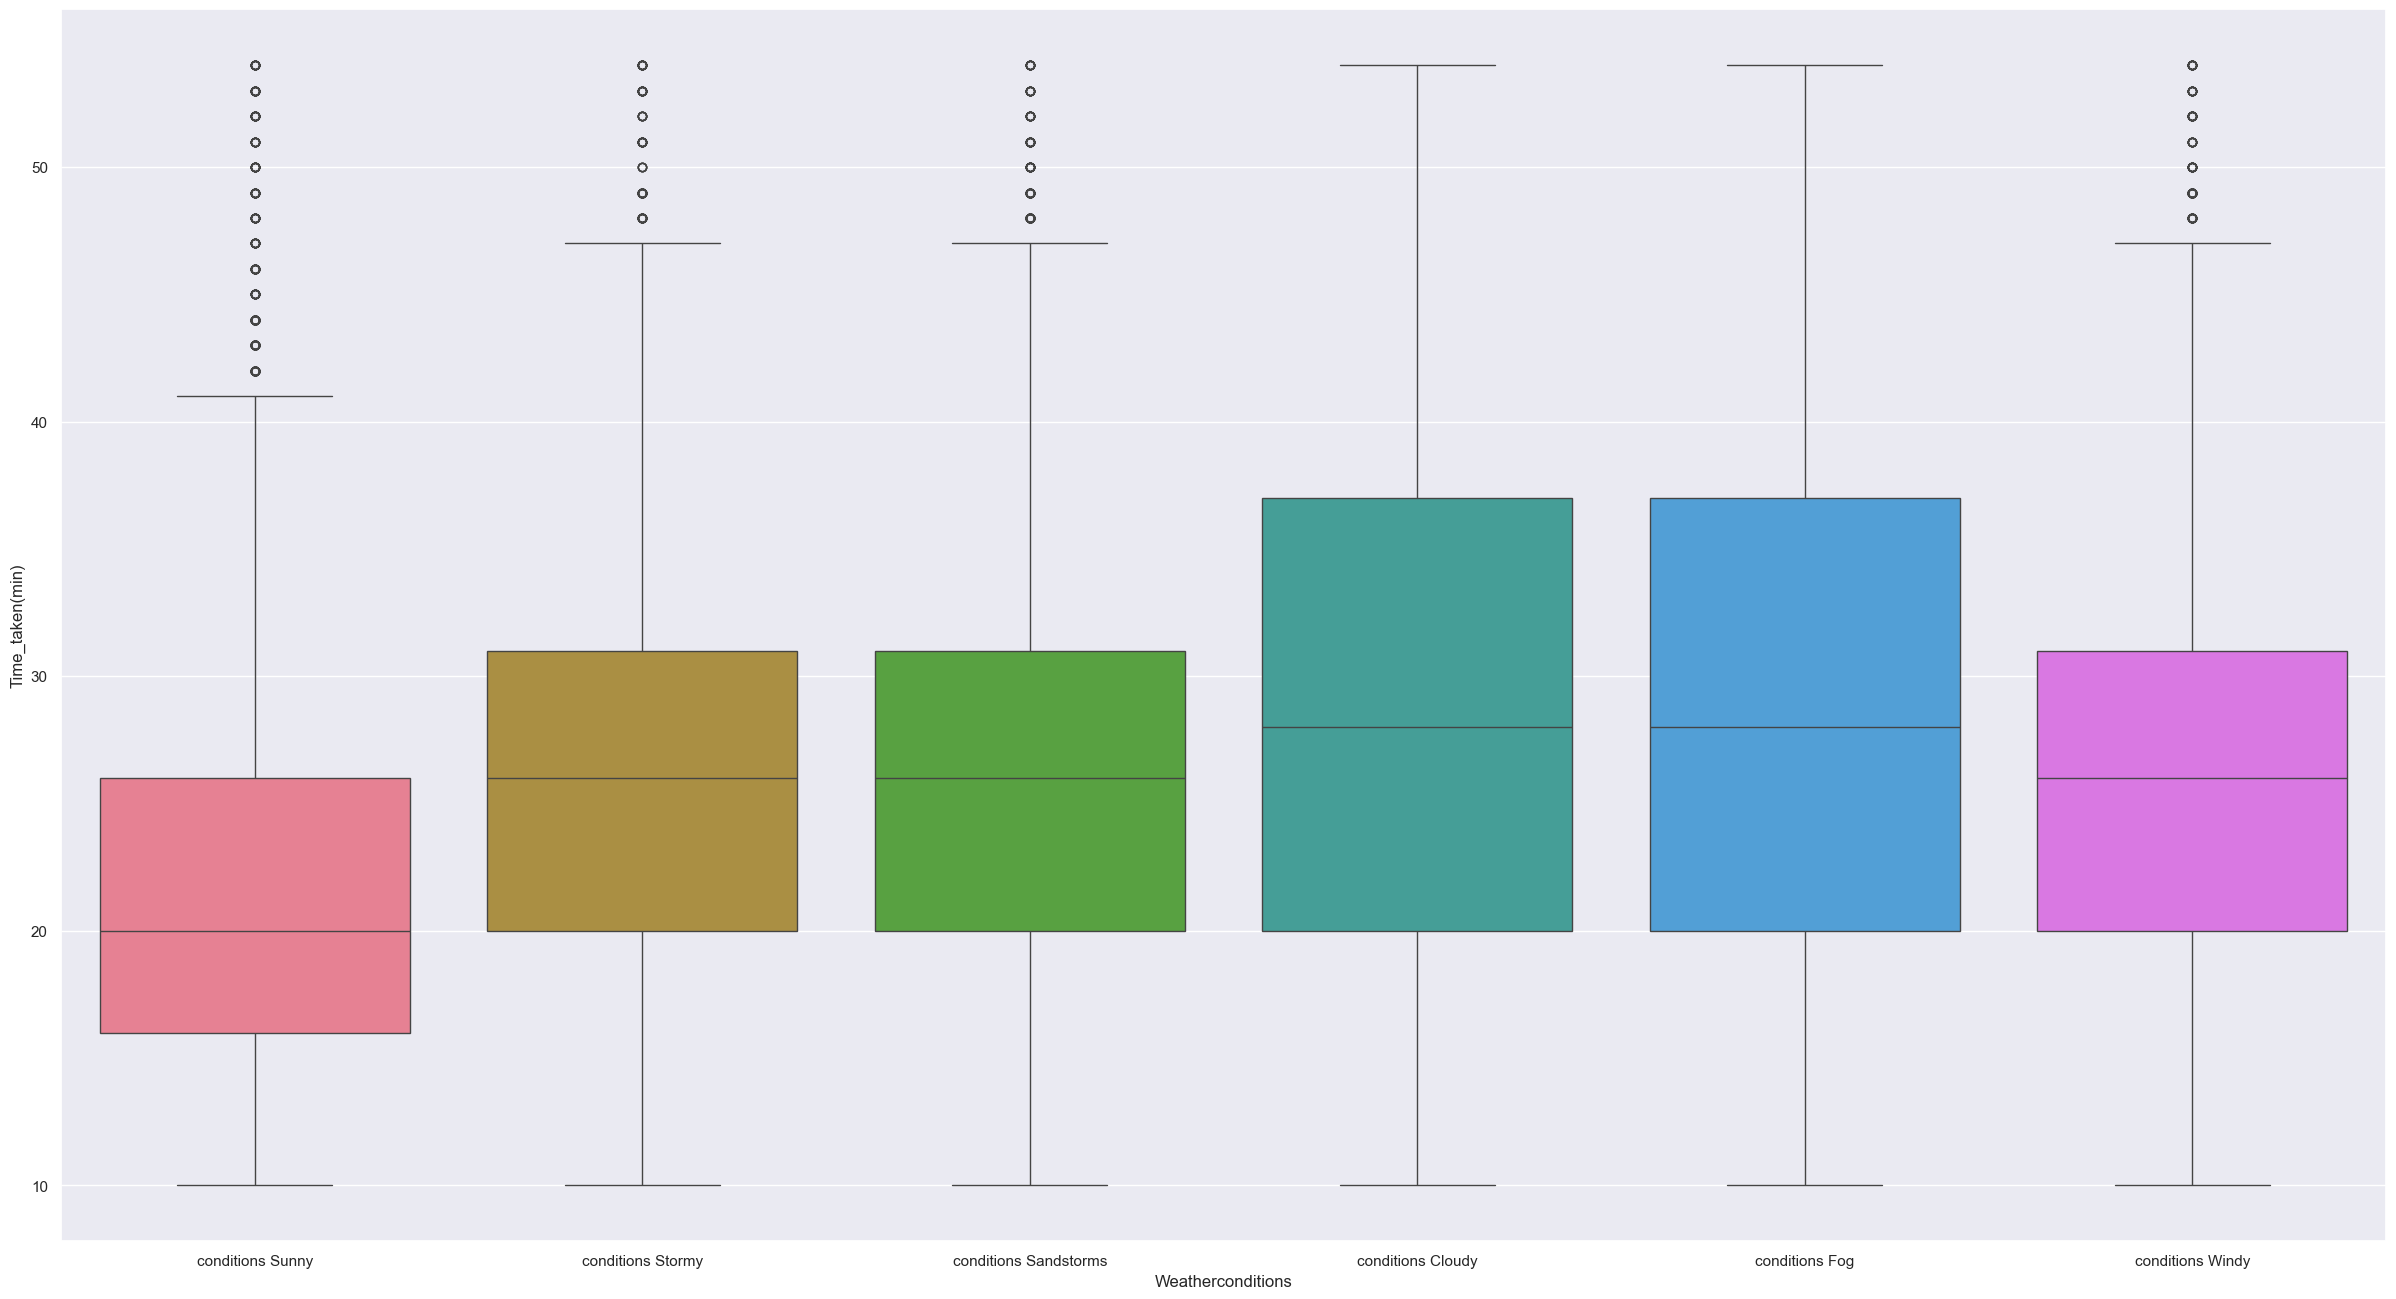

In [69]:
sns.boxplot(x='Weatherconditions', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Weatherconditions')

#### Hipótese 12: A densidade do tráfego pode impactar o tempo de entrega
VERDADEIRA

<Axes: xlabel='Road_traffic_density', ylabel='Time_taken(min)'>

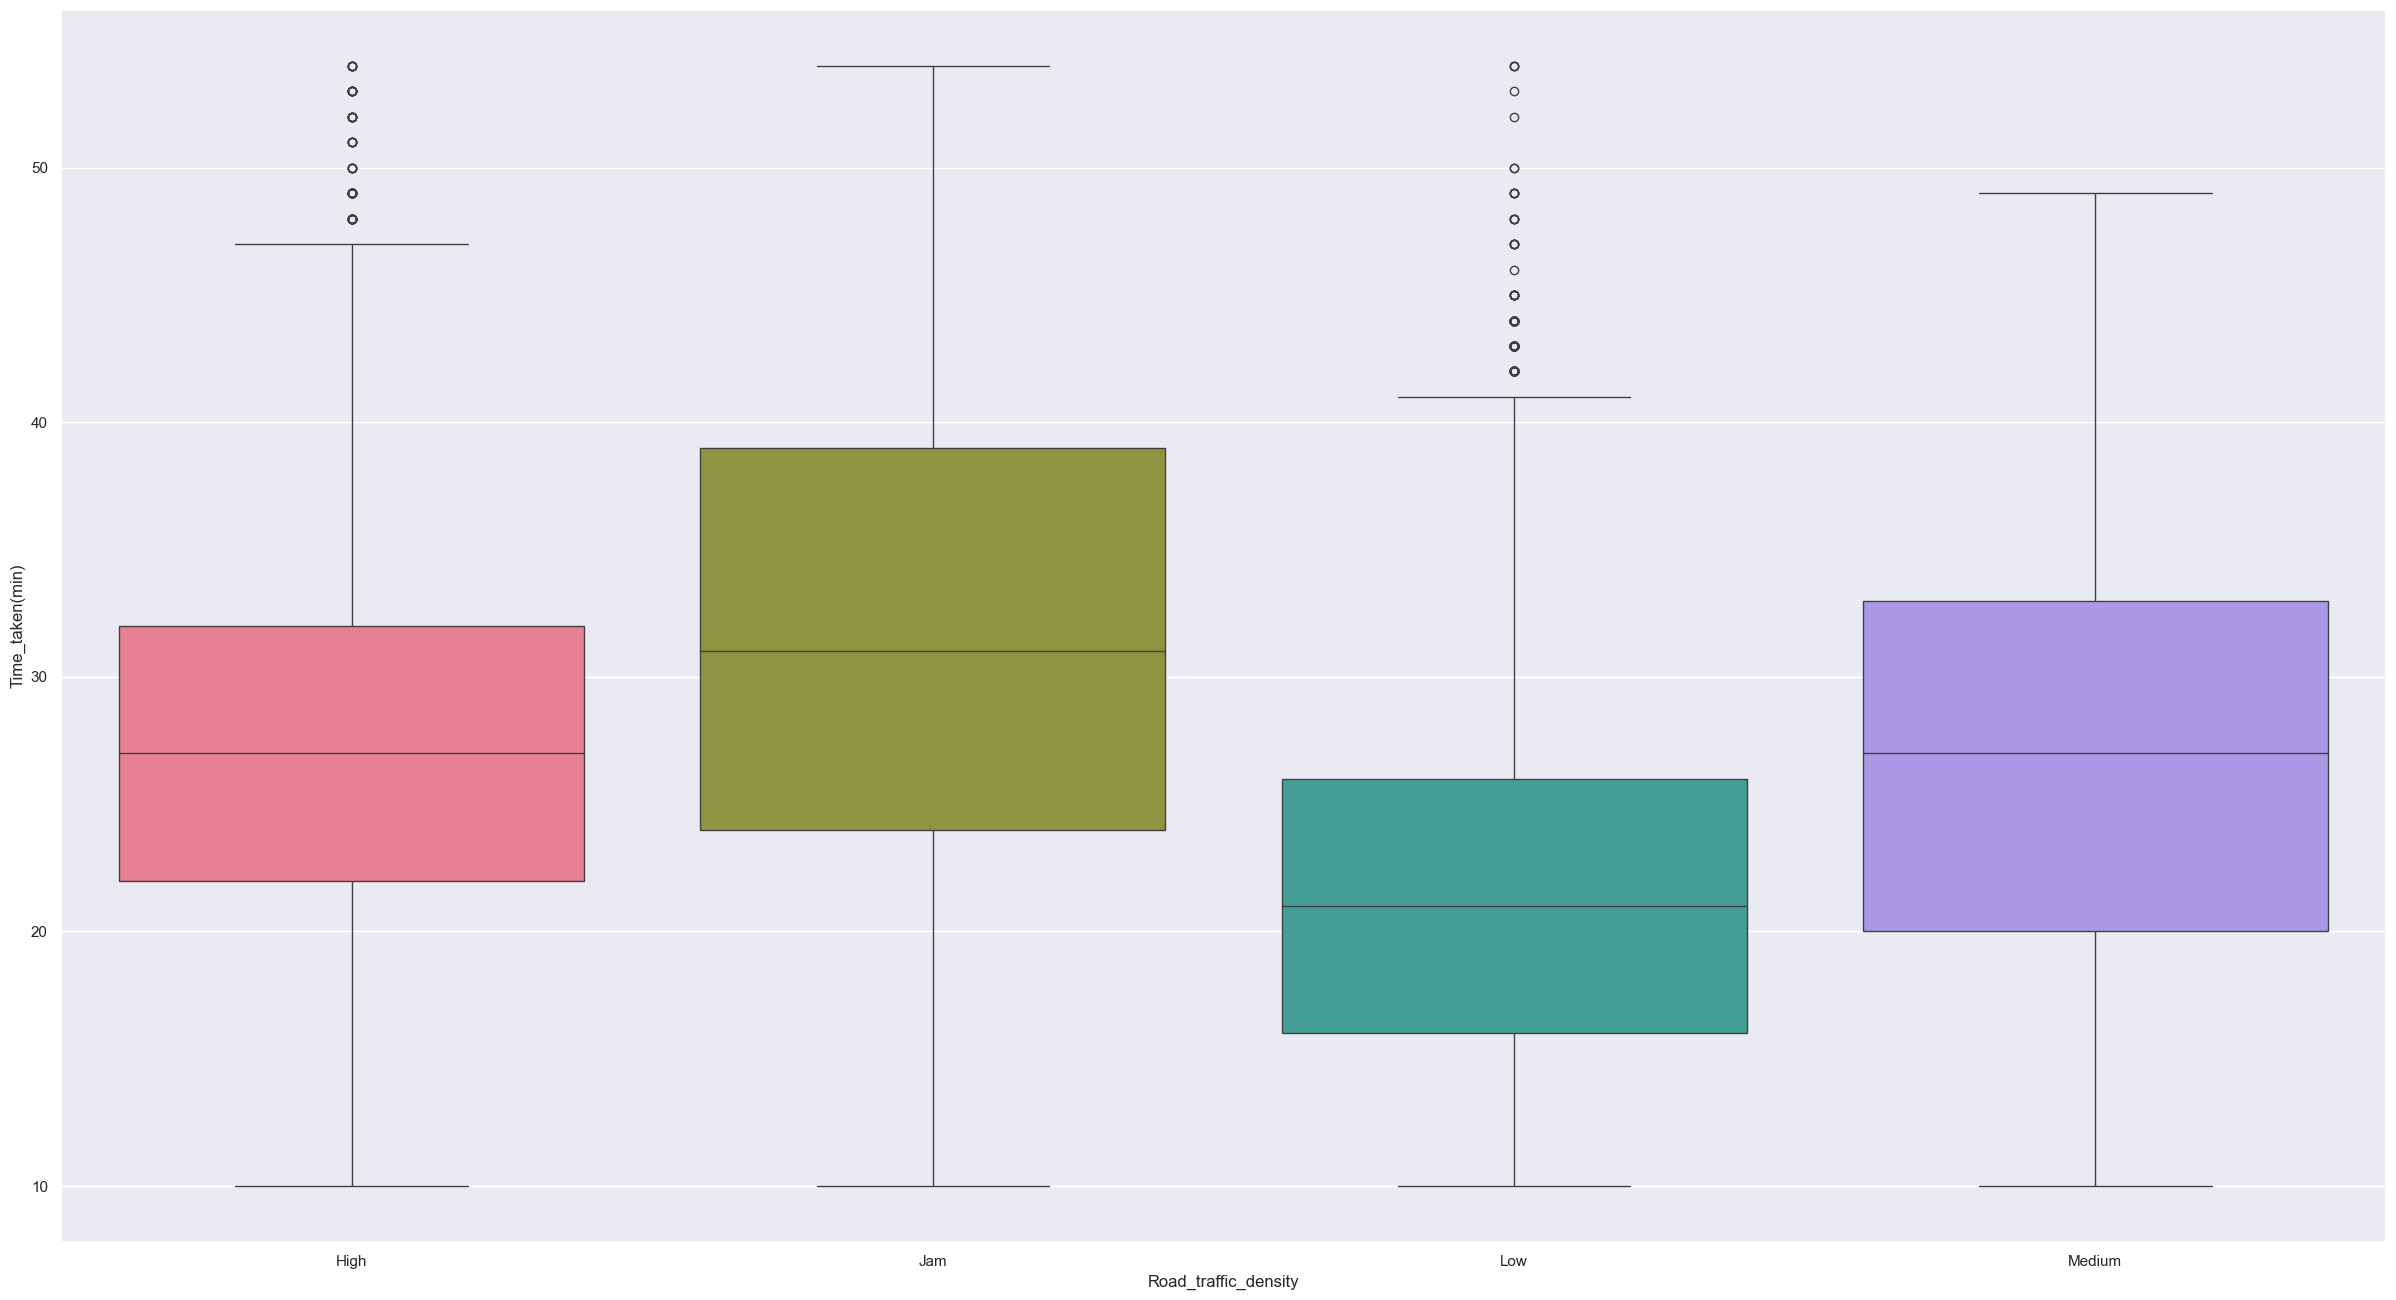

In [70]:
sns.boxplot(x='Road_traffic_density', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Road_traffic_density')

#### Hipótese 13: Festivais ou eventos na cidade podem afetar o tempo de entrega
VERDADEIRA

<Axes: xlabel='Festival', ylabel='Time_taken(min)'>

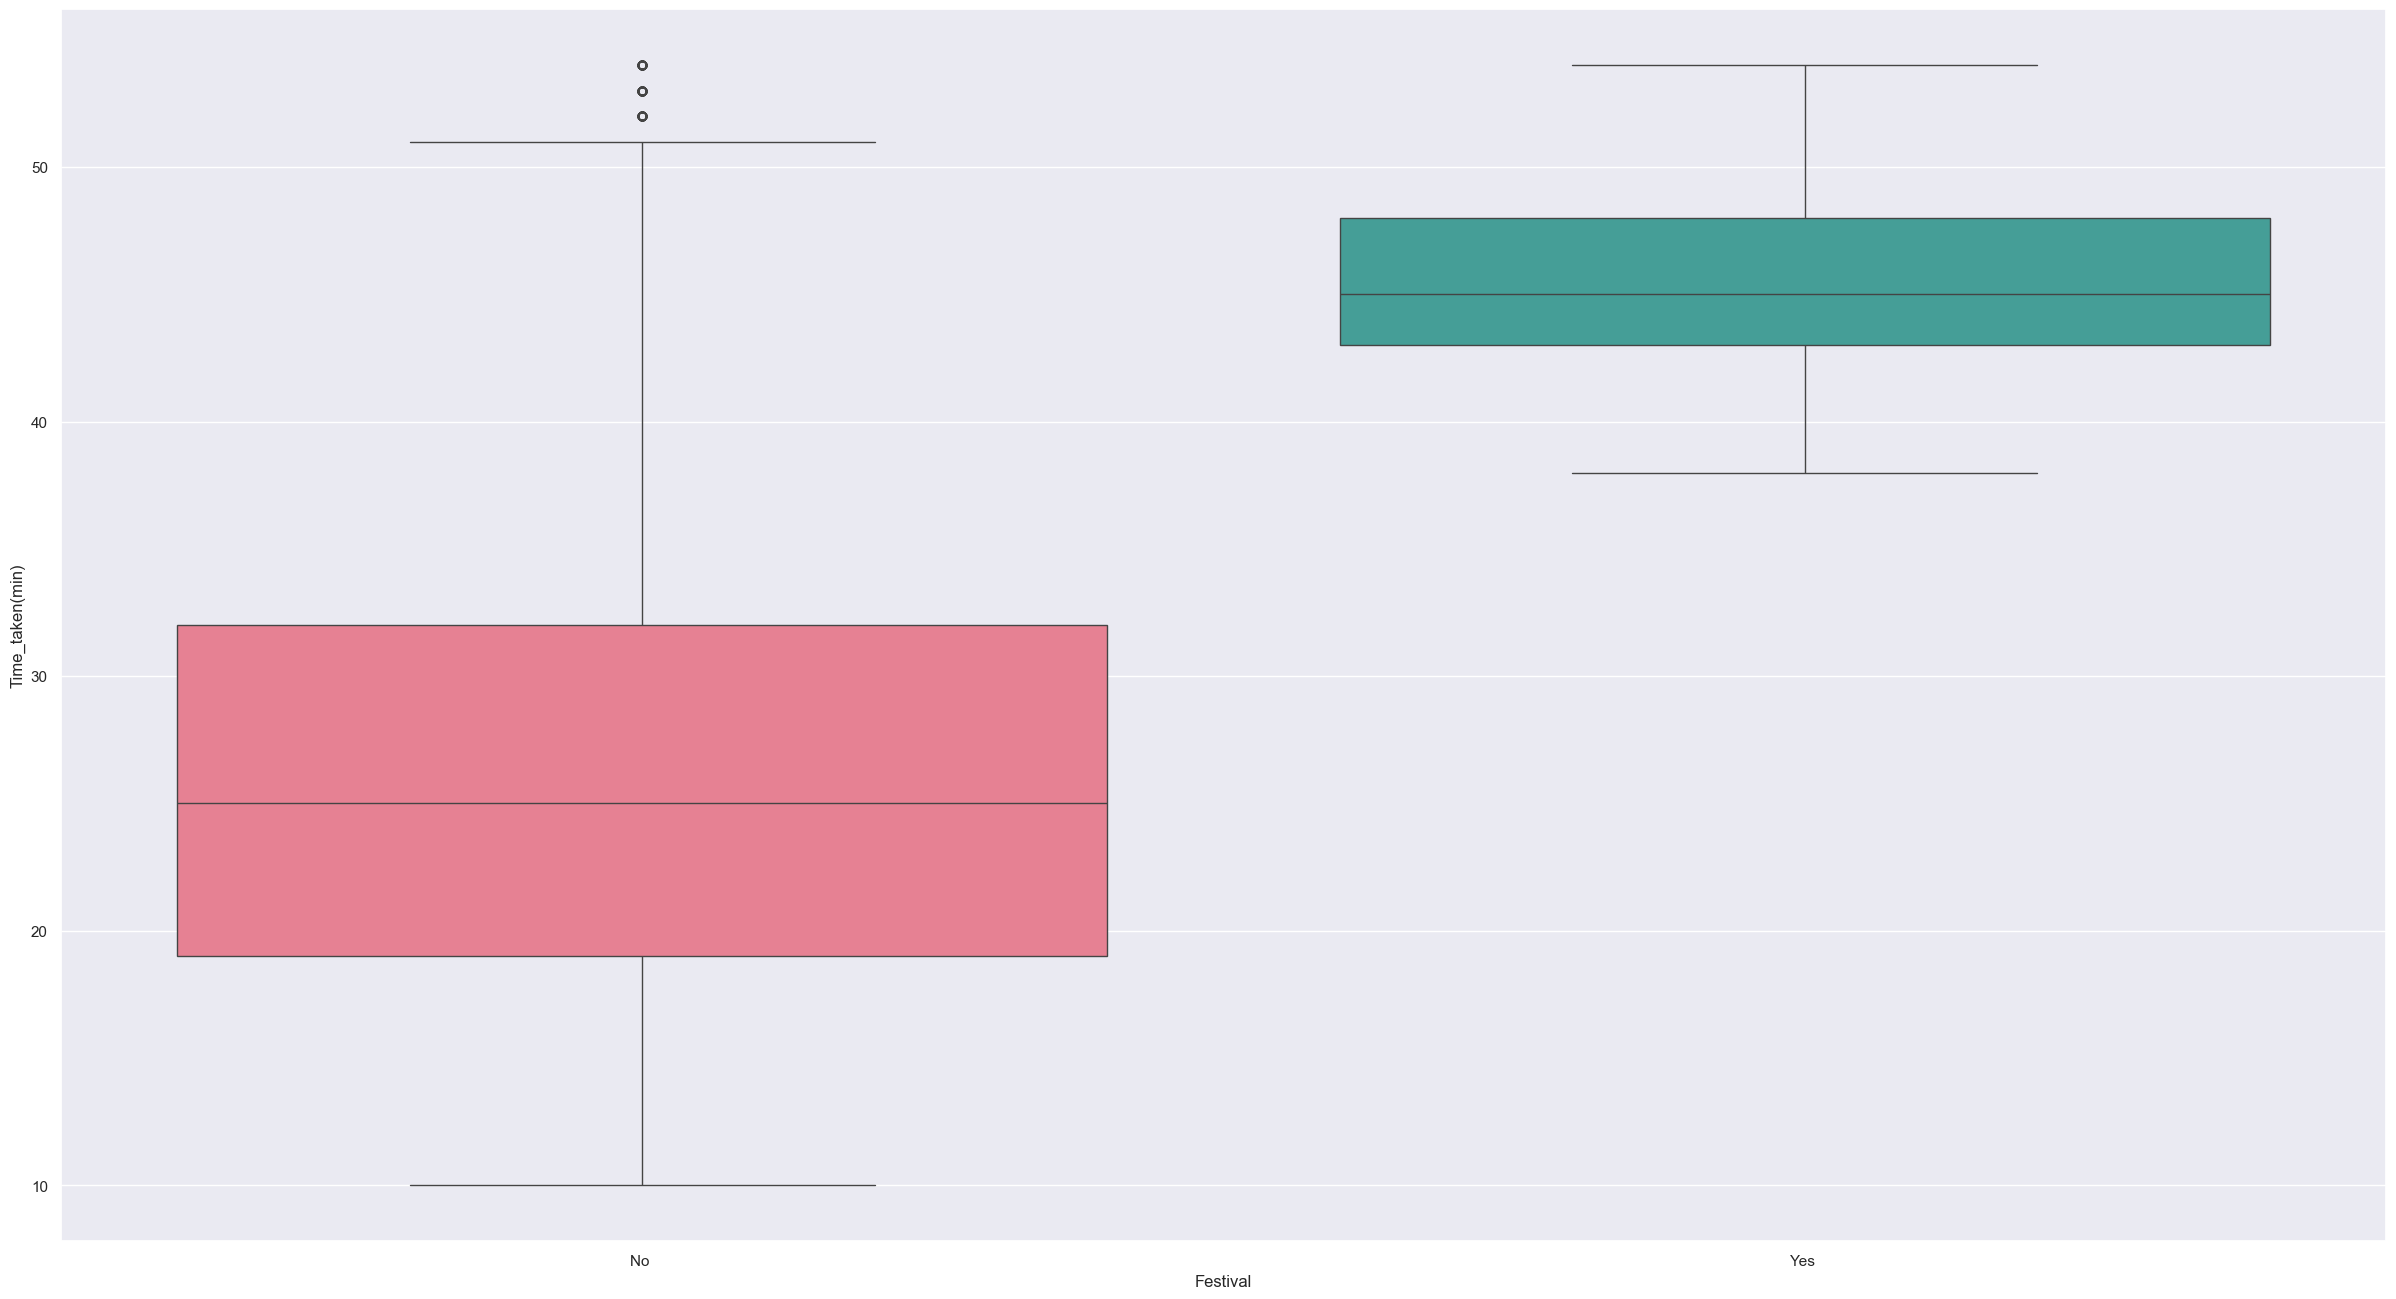

In [71]:
sns.boxplot(x='Festival', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Festival')

### 4.3 Análise Multivariada

In [72]:
num_attributes2 = df4.select_dtypes(include = ['int64', 'float64', 'int32'])
num_attributes2.drop(columns = ['year', 'is_year_start', 'is_year_end'], inplace = True)

<Axes: >

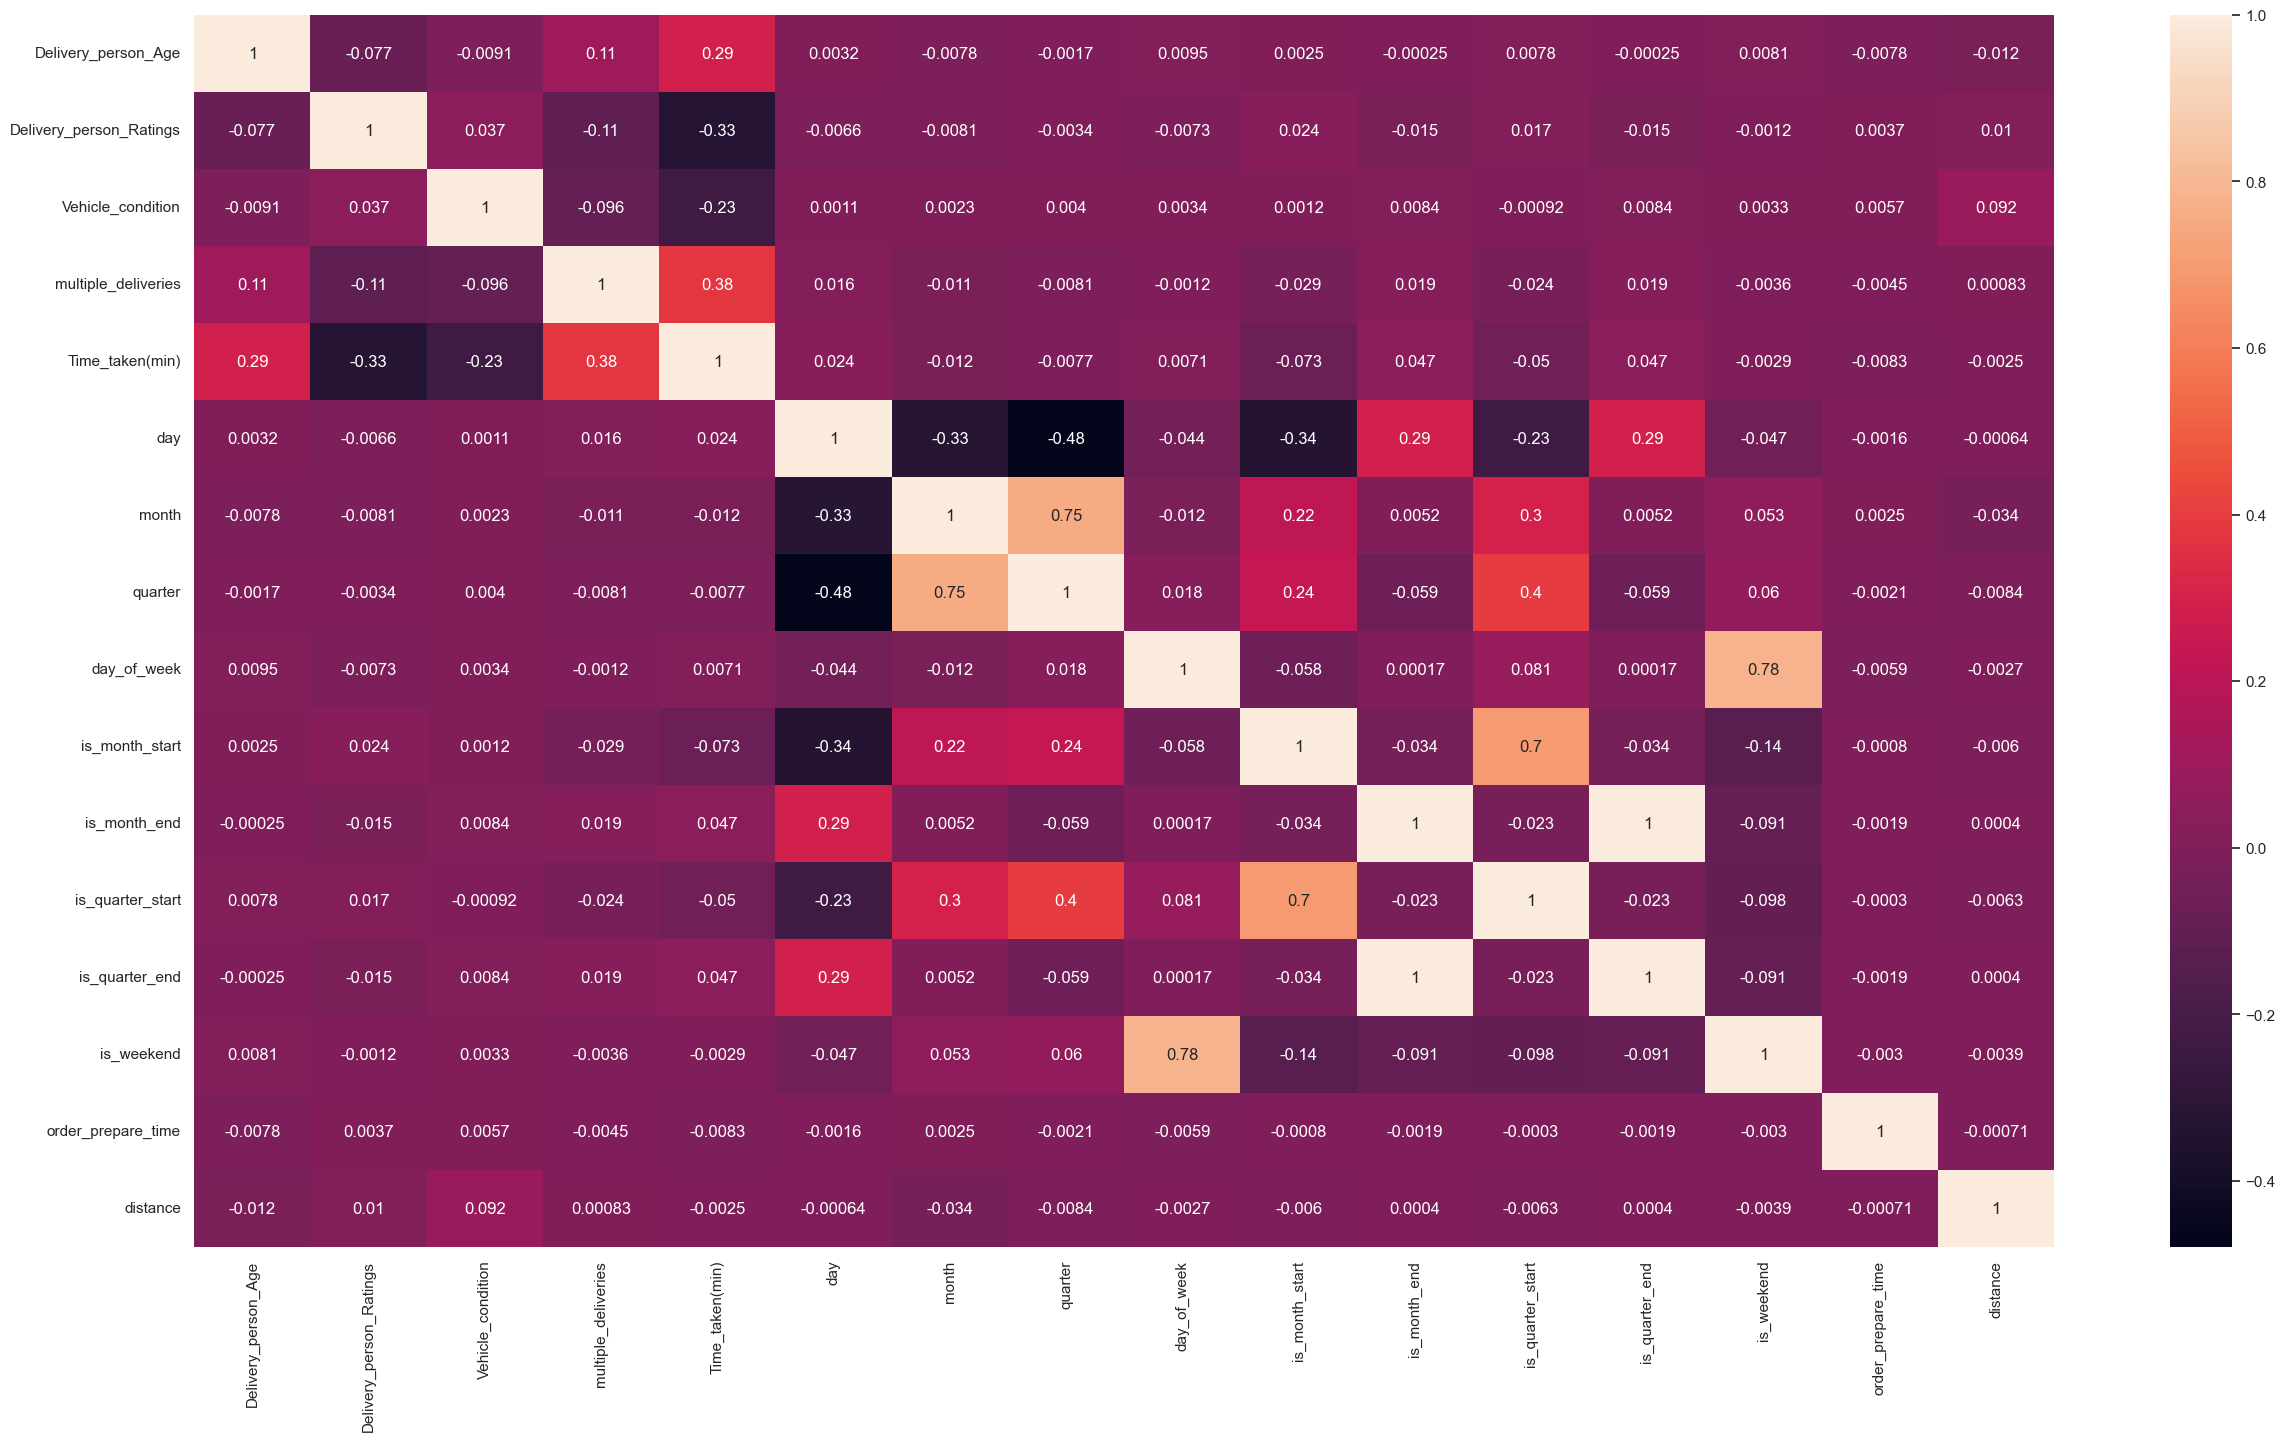

In [73]:
sns.heatmap(num_attributes2.corr(method = 'pearson'), annot = True)

## 5.0 Modelagem de Dados

In [172]:
df5 = df4.copy()

### 5.1 Normalização Z-Score

In [75]:
def normalizacao(df,col):
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = (df[col] - mean_val) / std_val
    return df

In [76]:
#normalizando a coluna Delivery_person_Ratings:

df_norm = normalizacao(df5, 'Delivery_person_Ratings')

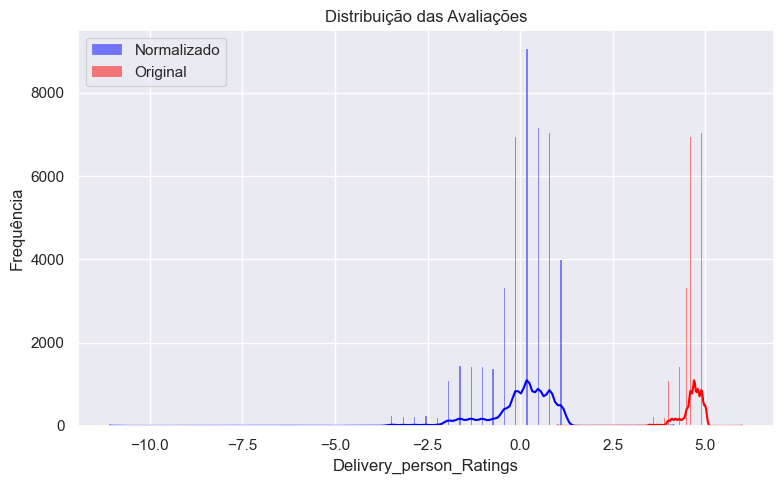

In [77]:
plt.figure(figsize=(8, 5))

# Histograma normalizado
sns.histplot(df_norm['Delivery_person_Ratings'], kde=True, color='blue', label='Normalizado', alpha=0.5)

# Histograma original (supondo que você tenha df_original ou similar)
sns.histplot(df4['Delivery_person_Ratings'], kde=True, color='red', label='Original', alpha=0.5)

plt.title('Distribuição das Avaliações')
plt.xlabel('Delivery_person_Ratings')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

### 5.2 Rescaling

In [123]:
#Min-Max Scaling:
def rescale_col(df, col):
    min_val = df[col].min()
    max_val = df[col].max()
    df[col] = (df[col] - min_val) / (max_val - min_val)
    return df

#Robust Scaling:
def robust_scale(df,col):
    scaler = RobustScaler()
    df[col] = scaler.fit_transform(df[col])
    return df

In [173]:
#variáveis numéricas:

num_attributes5 = df5.select_dtypes(include = ['int64', 'float64', 'int32'])
num_attributes5.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'Time_taken(min)', 'day', 'month', 'quarter',
       'year', 'day_of_week', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end',
       'is_weekend', 'order_prepare_time', 'distance'],
      dtype='object')

In [174]:
#colunas que serão rescaladas, sem as colunas booleanas:
num_cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'day', 'month', 'quarter',
       'day_of_week', 'order_prepare_time', 'distance']

#fazendo o rescaling nas colunas numéricas:
for i in num_cols:
    df5 = rescale_col(df5,i)

### 5.3 Variável Resposta

In [175]:
df5['Time_taken(min)'] = np.log1p(df5['Time_taken(min)'])

### 5.4 Encoding:


In [176]:
df6 = df5.drop(columns= ['Delivery_person_ID'])

In [177]:
#Label Encoding:
def label_encoding(df,col):
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])
    return df

In [178]:
#Ordinal Encoding:
ordem_cat = {'Low': 1,
             'Medium': 2,
             'High': 3,
             'Jam': 4}

df6['Road_traffic_density'] = df6['Road_traffic_density'].map(ordem_cat)

In [179]:
#Demais variáveis categóricas:
cat_df6 = df6.select_dtypes(include = ['object'])

#colunas:
cat_columns = cat_df6.columns

#aplicando o Label Encoding:
for i in cat_columns:
    df6 = label_encoding(df6,i)

## 6.0 Seleção de Atributos

In [181]:
df7 = df6.copy()

In [ ]:
#Separando em treino e teste:

X = df7.drop(columns= ['Time_taken(min)'])
y = df7['Time_taken(min)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

### 6.1 Feature Importance - Floresta Aleatória

In [148]:
#instanciando o modelo:
model = RandomForestRegressor()

#treinando o modelo:
model.fit(X_train, y_train)

#verificando as importâncias das features:
importances = model.feature_importances_

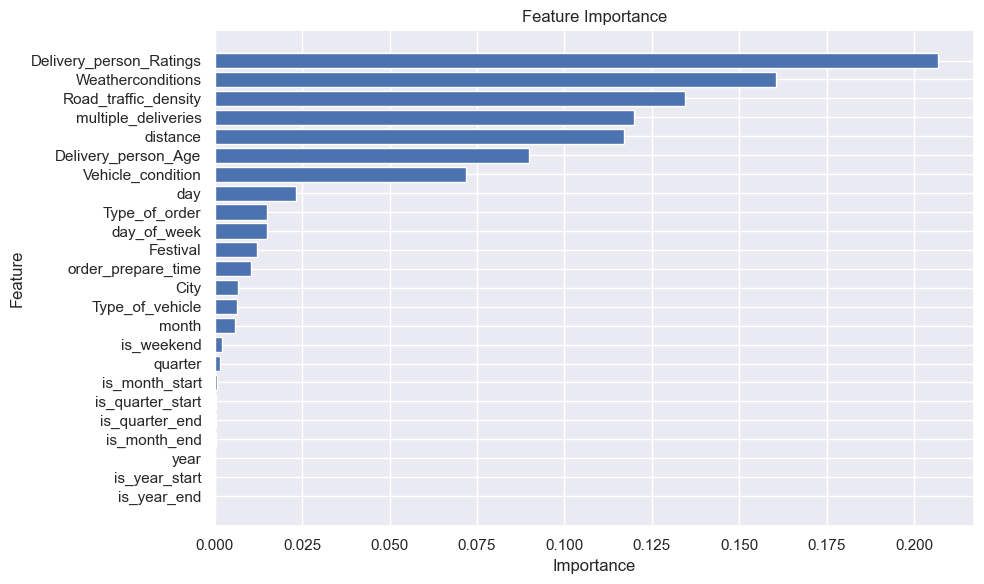

In [153]:
#Nome das variáveis:
feature_names = X_train.columns 

#Ordenando as importâncias e os nomes das variáveis:
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Gráfico de barras horizontais:
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_importances)), sorted_importances[::-1], color='b', align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names[::-1])

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.tight_layout()
plt.show()

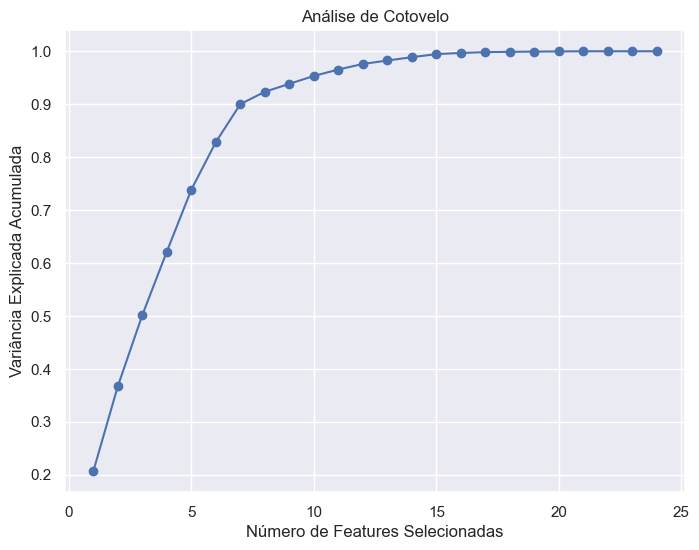

In [156]:
#Análise de cotovelo:

num_features = len(importances)

plt.figure(figsize=[8,6])
plt.plot(range(1,num_features +1), np.cumsum(sorted_importances), marker = 'o', linestyle ='-')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Análise de Cotovelo')
plt.grid(True)
plt.show()

### 6.2 Regularização

#### 6.2.1 Regularização Lasso (L1)

In [158]:
lasso_model = Lasso(alpha=0.005, random_state=42)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.005, random_state=42)

In [160]:
select_model = SelectFromModel(lasso_model)
select_model.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=42))

In [162]:
select_features = X_train.columns[select_model.get_support()]
print(select_features)

Index(['Delivery_person_Age', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_vehicle', 'multiple_deliveries',
       'Festival', 'City'],
      dtype='object')


### 6.3 BORUTA

In [165]:
rf = RandomForestRegressor(n_jobs = -1)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	17


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	17


In [166]:
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.tolist()
cols_selected_boruta

['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Weatherconditions',
 'Road_traffic_density',
 'Vehicle_condition',
 'multiple_deliveries',
 'distance']

## 7.0 Machine Learning Models

In [182]:
df8 = df7.copy()

In [184]:
X = df8[cols_selected_boruta]
y = df8['Time_taken(min)']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.15, stratify=y, random_state=42)

In [188]:
#Métricas:

def calculate_regression_metrics(nome_algoritmo, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    df = pd.DataFrame({
        'Algoritmo': [nome_algoritmo],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse]
    })

    return df

### 7.1 Regressão Linear

In [192]:
#definiindo o modelo:
lr = LinearRegression()

#treinamento:
lr.fit(X_train, y_train)

#previsões:
y_pred = lr.predict(X_test)

In [193]:
metricas_lr = calculate_regression_metrics('Linear Regression', np.expm1(y_test), np.expm1(y_pred))
metricas_lr

,Algoritmo,MAE,MSE,RMSE
0,Linear Regression,5.428987,46.949512,6.851971


### 7.2 Random Forest Regressor

In [194]:
#definiindo o modelo:
rf = RandomForestRegressor()

#treinamento:
rf.fit(X_train, y_train)

#previsões:
y_pred = rf.predict(X_test)

In [195]:
metricas_rf = calculate_regression_metrics('Random Forest Regressor', np.expm1(y_test), np.expm1(y_pred))
metricas_rf

,Algoritmo,MAE,MSE,RMSE
0,Random Forest Regressor,3.376244,18.697098,4.324014
